In [143]:
# Step 1: Imports + base path

In [144]:
# 1) Imports + base path
import os, re, json, hashlib
from typing import Iterator, Dict, Any, List, Tuple
import numpy as np
import pandas as pd
import networkx as nx
from IPython.display import display

# Colab Drive (skip if already mounted)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

BASE_PATH = '/content/drive/MyDrive/logs_bundle2'   # adjust if needed
print("Looking for logs in:", BASE_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking for logs in: /content/drive/MyDrive/logs_bundle2


In [145]:
#Step 2: Time helpers (robust + consistent)

In [146]:
# 2) Time helpers
_TZ_ABBR = {
    "UTC":"+0000", "GMT":"+0000",
    "EDT":"-0400", "EST":"-0500",
    "PDT":"-0700", "PST":"-0800",
    "CDT":"-0500", "CST":"-0600",
    "MDT":"-0600", "MST":"-0700",
}

def _normalize_zoned_strings(s):
    def fix_one(x):
        if not isinstance(x, str): return x
        m = re.search(r"\b(UTC|GMT|EDT|EST|PDT|PST|CDT|CST|MDT|MST)\b", x)
        return x.replace(m.group(1), _TZ_ABBR[m.group(1)]) if m else x
    return s.astype("string").map(fix_one) if isinstance(s, pd.Series) else fix_one(s)

def to_epoch_series(ts_like) -> pd.Series:
    s = pd.Series(ts_like)
    s = _normalize_zoned_strings(s)
    ts = pd.to_datetime(s, utc=True, errors="coerce")
    i64 = ts.astype("int64")              # ns from epoch
    i64 = i64.mask(ts.isna(), np.nan)     # NaT -> NaN
    return (i64 / 1e9).astype("float64")

def parse_ts_to_epoch(ts_val) -> float | None:
    if ts_val is None:
        return None
    v = float(to_epoch_series([ts_val]).iloc[0])
    return None if np.isnan(v) else v

def slice_window(df: pd.DataFrame, t0: float, t1: float) -> pd.DataFrame:
    if not isinstance(df, pd.DataFrame) or df.empty or 'ts_epoch' not in df:
        return df.iloc[0:0] if isinstance(df, pd.DataFrame) else pd.DataFrame()
    if t0 is None or t1 is None:
        return df.iloc[0:0]
    m = (df['ts_epoch'] >= t0) & (df['ts_epoch'] <= t1)
    return df.loc[m]


In [147]:
def _first_nonempty(*vals):
    for v in vals:
        if isinstance(v, str) and v.strip():
            return v
    return None

def extract_message_text(m: dict) -> str | None:
    c1 = m.get("message")
    c2 = (m.get("msg") or {}).get("content")
    c3 = (m.get("message_obj") or {}).get("content")
    # sometimes content is a list of segments: [{"type":"text","text":"..."}]
    def norm(c):
        if c is None: return None
        if isinstance(c, str): return c
        if isinstance(c, list):
            parts = []
            for seg in c:
                t = seg.get("text") if isinstance(seg, dict) else None
                if isinstance(t, str): parts.append(t)
            return "\n".join(parts) if parts else None
        if isinstance(c, dict):
            return c.get("text") or c.get("content")
        return None
    return _first_nonempty(*(norm(x) for x in (c1, c2, c3)))


In [148]:
import re
from typing import Dict, Any, Optional

TRACE_RE = re.compile(r"<trace:([0-9a-f]{32})>", re.IGNORECASE)

def extract_trace_from_question(text: Optional[str]) -> Optional[str]:
    if not isinstance(text, str):
        return None
    m = TRACE_RE.search(text)
    return m.group(1) if m else None

def load_interaction_questions(case_dir: str) -> dict[str, dict]:
    """
    Returns: { trace_id: {"text": question_text, "ts_epoch": float|None} }
    Looks in interactions.jsonl or interaction.jsonl for type=='run_start'.
    """
    out = {}
    for fname in ("interactions.jsonl", "interaction.jsonl"):
        path = os.path.join(case_dir, fname)
        if not os.path.exists(path):
            continue
        for obj in read_jsonl(path):
            if obj.get("type") != "run_start":
                continue
            q = obj.get("question")
            tid = extract_trace_from_question(q)
            if not tid:
                tid = (obj.get("trace") or {}).get("trace_id")
            if tid:
                out[tid] = {
                    "text": q,
                    "ts_epoch": parse_ts_to_epoch(obj.get("ts")) if obj.get("ts") else None,
                }
    return out


In [149]:
#Step 3: Resource loaders (fixed load_gpu and tolerant load_vmstat)

In [150]:
# 3) Resource loaders
def load_http(base: str) -> pd.DataFrame:
    p = os.path.join(base, "http.tsv")
    if not os.path.exists(p):
        return pd.DataFrame(columns=["ts_epoch"])
    df = pd.read_csv(p, sep="\t", header=None, names=["ts","ip","url"], dtype=str)
    tse = to_epoch_series(df["ts"])
    out = pd.DataFrame({"ts_epoch": tse})
    return out.dropna(subset=["ts_epoch"]).sort_values("ts_epoch").reset_index(drop=True)

def load_dns(base: str) -> pd.DataFrame:
    p = os.path.join(base, "dns.tsv")
    if not os.path.exists(p):
        return pd.DataFrame(columns=["ts_epoch"])
    df = pd.read_csv(p, sep="\t", header=None, names=["ts","host"], dtype=str)
    tse = to_epoch_series(df["ts"])
    out = pd.DataFrame({"ts_epoch": tse})
    return out.dropna(subset=["ts_epoch"]).sort_values("ts_epoch").reset_index(drop=True)

def load_traffic(base: str) -> pd.DataFrame:
    p = os.path.join(base, "traffic.tsv")
    cols = ["ts_epoch","bps","pps","bytes","packets"]
    if not os.path.exists(p):
        return pd.DataFrame(columns=cols)
    df = pd.read_csv(p, sep=r"\s+|\t", engine="python")
    ts_col = None
    for c in df.columns:
        if str(c).lower() in ("ts","timestamp","time","date","datetime"):
            ts_col = c; break
    if ts_col is None:
        ts_col = df.columns[0]
    tse = to_epoch_series(df[ts_col])
    out = pd.DataFrame({
        "ts_epoch": tse,
        "bps":     pd.to_numeric(df.get("bps",     np.nan), errors="coerce"),
        "pps":     pd.to_numeric(df.get("pps",     np.nan), errors="coerce"),
        "bytes":   pd.to_numeric(df.get("bytes",   np.nan), errors="coerce"),
        "packets": pd.to_numeric(df.get("packets", np.nan), errors="coerce"),
    })
    return out.dropna(subset=["ts_epoch"]).sort_values("ts_epoch").reset_index(drop=True)

def load_strace_stats(base: str) -> pd.DataFrame:
    p = os.path.join(base, "strace_stats.tsv")
    cols = ["ts_epoch","syscalls_total","read_ps","write_ps","open_ps","top_syscall"]
    if not os.path.exists(p):
        return pd.DataFrame(columns=cols)
    df = pd.read_csv(p, sep=r"\s+|\t", engine="python")
    ts_col = None
    for c in df.columns:
        if str(c).lower() in ("ts","timestamp","time","date","datetime"):
            ts_col = c; break
    if ts_col is None:
        ts_col = df.columns[0]
    tse = to_epoch_series(df[ts_col])
    out = pd.DataFrame({
        "ts_epoch":       tse,
        "syscalls_total": pd.to_numeric(df.get("syscalls_total", np.nan), errors="coerce"),
        "read_ps":        pd.to_numeric(df.get("read_ps",        np.nan), errors="coerce"),
        "write_ps":       pd.to_numeric(df.get("write_ps",       np.nan), errors="coerce"),
        "open_ps":        pd.to_numeric(df.get("open_ps",        np.nan), errors="coerce"),
        "top_syscall":    df.get("top_syscall", pd.Series([None]*len(df))),
    })
    return out.dropna(subset=["ts_epoch"]).sort_values("ts_epoch").reset_index(drop=True)

def load_vmstat(base: str) -> pd.DataFrame:
    """
    Parse vmstat.log into ['ts_epoch','us','cs','load1'].
    Rules:
      - If timestamp has timezone/offset → parse as-is (no extra localize).
      - If naive 'YYYY-mm-dd HH:MM:SS' → assume America/New_York, then convert to UTC.
      - If trailing integer epoch → use it directly (no tz ops).
    """
    import os, re, numpy as np, pandas as pd
    p = os.path.join(base, "vmstat.log")
    cols = ["ts_epoch","us","cs","load1"]
    if not os.path.exists(p):
        return pd.DataFrame(columns=cols)

    # ---------- Try "table" mode (space/tab separated columns) ----------
    try:
        df = pd.read_csv(p, sep=r"\s+|\t", engine="python")
        # candidate timestamp column: ts/timestamp/time/date/datetime else last column
        ts_col = None
        for c in df.columns:
            if str(c).lower() in ("ts","timestamp","time","date","datetime"):
                ts_col = c; break
        if ts_col is None:
            ts_col = df.columns[-1]

        ts = pd.to_datetime(df[ts_col], errors="coerce", utc=False)
        # If all tz-naive → localize to NY and convert; if tz-aware → just convert to UTC
        if ts.dt.tz is None:
            # Naive → treat as local NY
            ts = ts.dt.tz_localize("America/New_York", nonexistent="shift_forward", ambiguous="NaT").dt.tz_convert("UTC")
        else:
            ts = ts.dt.tz_convert("UTC")

        out = pd.DataFrame({
            "ts_epoch": (ts.astype("int64") / 1e9).astype("float64"),
            "us": pd.to_numeric(df.get("us", np.nan), errors="coerce"),
            "cs": pd.to_numeric(df.get("cs", np.nan), errors="coerce"),
            "load1": pd.to_numeric(df.get("load1", np.nan), errors="coerce"),
        }).dropna(subset=["ts_epoch"]).sort_values("ts_epoch").reset_index(drop=True)

        # guarantee columns exist
        for c in cols:
            if c not in out: out[c] = np.nan
        return out[cols]
    except Exception:
        pass  # fall through to line mode

    # ---------- Classic vmstat lines with trailing timestamp/epoch ----------
    patt_ts = re.compile(r"(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}(?:\.\d+)?)\s*$")
    patt_epoch = re.compile(r"(\d{10})(?:\.\d+)?\s*$")
    header_idx = {}
    header_seen = False
    rows = []
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            s = line.rstrip()
            if not s:
                continue
            # header mapping
            if "------cpu-----" in s or s.strip().startswith("r b"):
                parts = re.split(r"\s+", s.strip())
                for i, tok in enumerate(parts):
                    if tok == "us": header_idx["us"] = i
                    if tok == "cs": header_idx["cs"] = i
                header_seen = True
                continue

            ts_epoch = None
            ts_end_idx = len(s)

            # (1) try YYYY-mm-dd HH:MM:SS[.sss]
            m = patt_ts.search(s)
            if m:
                ts_end_idx = m.start()
                ts = pd.to_datetime(m.group(1), errors="coerce", utc=False)
                if ts is not pd.NaT:
                    # Naive → local NY → UTC; Aware → UTC
                    if ts.tzinfo is None:
                        ts = ts.tz_localize("America/New_York",
                                            nonexistent="shift_forward",
                                            ambiguous="NaT").tz_convert("UTC")
                    else:
                        ts = ts.tz_convert("UTC")
                    ts_epoch = float(ts.timestamp())

            # (2) else try integer epoch
            if ts_epoch is None:
                m2 = patt_epoch.search(s)
                if m2:
                    try:
                        ts_epoch = float(m2.group(1))
                    except Exception:
                        ts_epoch = None

            if ts_epoch is None:
                continue

            # parse body numbers before timestamp
            body = s[:ts_end_idx].strip()
            nums = re.split(r"\s+", body) if body else []
            us = cs = np.nan

            if header_seen and "us" in header_idx and header_idx["us"] < len(nums):
                try: us = float(nums[header_idx["us"]])
                except: pass
            if header_seen and "cs" in header_idx and header_idx["cs"] < len(nums):
                try: cs = float(nums[header_idx["cs"]])
                except: pass

            # --- headerless fallback ---
            if (np.isnan(us) or np.isnan(cs)) and len(nums) >= 6:
                # Classic vmstat columns end with: [in, cs, us, sy, id, wa] (and maybe ... st)
                # If 'st' present, tail length >= 7 → us = -5, cs = -6
                # If 'st' missing, tail length == 6 → us = -4, cs = -5
                try:
                    if len(nums) >= 7:
                        us = float(nums[-5]) if np.isnan(us) else us
                        cs = float(nums[-6]) if np.isnan(cs) else cs
                    else:  # len == 6 tail
                        us = float(nums[-4]) if np.isnan(us) else us
                        cs = float(nums[-5]) if np.isnan(cs) else cs
                except Exception:
                    pass

            rows.append({"ts_epoch": ts_epoch, "us": us, "cs": cs, "load1": np.nan})

    if not rows:
        return pd.DataFrame(columns=cols)
    return pd.DataFrame(rows, columns=cols).sort_values("ts_epoch").reset_index(drop=True)


def load_gpu(base: str) -> pd.DataFrame:
    p = os.path.join(base, "gpu.csv")
    if not os.path.exists(p):
        return pd.DataFrame(columns=["ts_epoch","gpu_util","gpu_mem_mb","power_w"])

    df = pd.read_csv(p)

    # timestamps are naive local; localize to America/New_York -> UTC
    ts_col = df.columns[0]                     # "timestamp"
    ts = pd.to_datetime(df[ts_col], errors="coerce")
    ts = ts.dt.tz_localize("America/New_York", nonexistent="shift_forward", ambiguous="NaT").dt.tz_convert("UTC")
    ts_epoch = ts.astype("int64")/1e9          # float seconds

    # pick column names (NO boolean 'or' on Series!)
    def pick(cands):
        for c in cands:
            if c in df.columns:
                return c
        return None

    util_col = pick(["util.gpu %", "utilization.gpu [%]"])
    mem_col  = pick(["mem.used MB", "memory.used [MiB]"])
    pow_col  = pick(["power W", "power.draw [W]"])

    def clean(name):
        if name is None:
            return pd.Series([np.nan]*len(df), dtype="float64")
        s = df[name].astype(str).str.replace(r"[^0-9.+-]", "", regex=True)
        return pd.to_numeric(s, errors="coerce")

    out = pd.DataFrame({
        "ts_epoch":   ts_epoch,
        "gpu_util":   clean(util_col),
        "gpu_mem_mb": clean(mem_col),
        "power_w":    clean(pow_col),
    })
    out = out.dropna(subset=["ts_epoch"]).sort_values("ts_epoch").reset_index(drop=True)
    return out[["ts_epoch","gpu_util","gpu_mem_mb","power_w"]]


In [151]:
#Step 4: Case discovery + JSONL reader

In [152]:
def list_case_dirs(base: str) -> List[str]:
    if not os.path.isdir(base): return []
    out = []
    for name in os.listdir(base):
        p = os.path.join(base, name)
        if os.path.isdir(p) and name.startswith('q_'):
            out.append(p)
    out.sort()
    return out

def extract_case_id(case_dir_path: str) -> str:
    name = os.path.basename(case_dir_path)
    m = re.search(r'trace_([0-9a-f]+)', name)
    return m.group(1) if m else name

def list_agent_files(case_dir_path: str) -> List[str]:
    out = []
    for fn in os.listdir(case_dir_path):
        if fn.endswith('.jsonl') and fn.startswith(('agent-', 'agent_')):
            out.append(os.path.join(case_dir_path, fn))
    out.sort()
    return out

def parse_idx_role(agent_path: str) -> Tuple[int, str]:
    fn = os.path.basename(agent_path)
    m = re.match(r'agent[-_](\d+)_([^.]+)\.jsonl$', fn)
    if m: return int(m.group(1)), m.group(2)
    m2 = re.match(r'agent[-_](\d+)\.jsonl$', fn)
    if m2: return int(m2.group(1)), 'unknown'
    raise ValueError(f"Unrecognized agent filename: {fn}")

def read_jsonl(path: str) -> Iterator[Dict[str, Any]]:
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            s = line.strip()
            if not s: continue
            try:
                yield json.loads(s)
            except json.JSONDecodeError:
                continue


In [153]:
def msg_trace_id(m: dict, efeat: dict) -> str | None:
    trc = efeat.get("trace_id")
    if not trc:
        trc = ((m.get("meta", {}).get("trace", {}) or {}).get("trace_id"))
    if not trc:
        trc = (m.get("meta", {}).get("headers", {}) or {}).get("X-Alarm-Trace")
    return trc

In [154]:
#Step 6: Edge key + feature builders (GPU/CPU included)

In [155]:
def msg_uid_from(m: dict) -> str:
    parts = {
        "ts": m.get("ts"),
        "round": m.get("round"),
        "turn": m.get("turn"),
        "src": (m.get("src") or {}).get("idx"),
        "dst": (m.get("dst") or {}).get("idx"),
        "trace": (m.get("meta",{}).get("trace",{}) or {}).get("trace_id"),
        "pid": (m.get("meta",{}) or {}).get("pid"),
        "tokens": (m.get("meta",{}).get("tokens",{}) or {}),
    }
    blob = json.dumps(parts, sort_keys=True, separators=(",",":"))
    return hashlib.md5(blob.encode("utf-8")).hexdigest()

def edge_features_from_msg(msg, http_df, dns_df, tr_df, vm_df, strace_df, gpu_df) -> dict:
    end_ts = float(msg.get("ts_epoch"))
    timing_ms = float(msg.get("meta", {}).get("timing_ms", 0.0) or 0.0)
    timing_s  = max(timing_ms/1000.0, 1.0)
    start_ts  = end_ts - timing_s

    hwin = slice_window(http_df,   start_ts, end_ts)
    dwin = slice_window(dns_df,    start_ts, end_ts)
    twin = slice_window(tr_df,     start_ts, end_ts)
    vwin = slice_window(vm_df,     start_ts, end_ts)
    swin = slice_window(strace_df, start_ts, end_ts)
    gwin = slice_window(gpu_df,    start_ts, end_ts)

    return {
        "ts": msg.get("ts"),
        "round": msg.get("round"),
        "turn": msg.get("turn"),
        # "message": (msg.get("message") or msg.get("content") or ""),
        "chars": len(msg.get("message", "") or ""),
        "prompt_tokens": (msg.get("meta",{}).get("tokens",{}) or {}).get("prompt"),
        "completion_tokens": (msg.get("meta",{}).get("tokens",{}) or {}).get("completion"),
        "timing_ms": timing_ms,
        "trace_id": (msg.get("meta",{}).get("trace",{}) or {}).get("trace_id"),
        "src_role": (msg.get("src") or {}).get("role"),
        "dst_role": (msg.get("dst") or {}).get("role"),

        "http_count_win": int(len(hwin)),
        "dns_count_win":  int(len(dwin)),

        "bps_win":    float(twin["bps"].mean())      if len(twin)    and "bps"     in twin else np.nan,
        "pps_win":    float(twin["pps"].mean())      if len(twin)    and "pps"     in twin else np.nan,
        "bytes_win":  float(twin["bytes"].sum())     if len(twin)    and "bytes"   in twin else np.nan,
        "pkts_win":   float(twin["packets"].sum())   if len(twin)    and "packets" in twin else np.nan,

        "us_mean_win":   float(vwin["us"].mean())    if len(vwin)    and "us"      in vwin else np.nan,
        "cs_mean_win":   float(vwin["cs"].mean())    if len(vwin)    and "cs"      in vwin else np.nan,
        "load1_win":     float(vwin["load1"].mean()) if len(vwin)    and "load1"   in vwin else np.nan,

        "syscalls_win":  float(swin["syscalls_total"].sum()) if len(swin) and "syscalls_total" in swin else np.nan,
        "read_ps_win":   float(swin["read_ps"].mean())       if len(swin) and "read_ps"        in swin else np.nan,
        "write_ps_win":  float(swin["write_ps"].mean())      if len(swin) and "write_ps"       in swin else np.nan,
        "open_ps_win":   float(swin["open_ps"].mean())       if len(swin) and "open_ps"        in swin else np.nan,

        "gpu_util_mean_win":  float(gwin["gpu_util"].mean())   if len(gwin) and "gpu_util"  in gwin else np.nan,
        "gpu_power_mean_win": float(gwin["power_w"].mean())    if len(gwin) and "power_w"   in gwin else np.nan,
        "gpu_mem_max_win":    float(gwin["gpu_mem_mb"].max())  if len(gwin) and "gpu_mem_mb" in gwin else np.nan,

        "start_ts": start_ts,
        "end_ts":   end_ts,
    }

def finalize_node_features(G: nx.MultiDiGraph, nid, messages, http_df, dns_df, tr_df, vm_df, strace_df, gpu_df):
    ts_list = [m.get("ts_epoch") for m in messages if m.get("ts_epoch") is not None]
    if not ts_list:
        if not G.has_node(nid): G.add_node(nid)
        G.nodes[nid].update({
            "n_msgs": 0, "n_out": 0, "out_ratio": 0.0,
            "first_ts": np.nan, "last_ts": np.nan, "duration_ms": np.nan,
            "http_req_count": 0, "dns_query_count": 0
        })
        return

    t0 = float(min(ts_list))
    t1 = float(max(ts_list))
    n_msgs = len(messages)
    n_out  = sum(1 for m in messages if m.get("direction") == "sent")

    if not G.has_node(nid): G.add_node(nid)
    G.nodes[nid].update({
        "n_msgs": n_msgs,
        "n_out": n_out,
        "out_ratio": n_out/max(1, n_msgs),
        "first_ts": t0,
        "last_ts":  t1,
        "duration_ms": (t1 - t0)*1000.0
    })

    hL = slice_window(http_df,   t0, t1)
    dL = slice_window(dns_df,    t0, t1)
    tL = slice_window(tr_df,     t0, t1)
    vL = slice_window(vm_df,     t0, t1)
    sL = slice_window(strace_df, t0, t1)
    gL = slice_window(gpu_df,    t0, t1)

    G.nodes[nid]["http_req_count"] = int(len(hL))
    G.nodes[nid]["dns_query_count"] = int(len(dL))
    G.nodes[nid]["bps_mean"]    = float(tL["bps"].mean())     if len(tL) and "bps"     in tL else np.nan
    G.nodes[nid]["pps_mean"]    = float(tL["pps"].mean())     if len(tL) and "pps"     in tL else np.nan
    G.nodes[nid]["bytes_total"] = float(tL["bytes"].sum())    if len(tL) and "bytes"   in tL else np.nan
    G.nodes[nid]["pkts_total"]  = float(tL["packets"].sum())  if len(tL) and "packets" in tL else np.nan
    G.nodes[nid]["us_mean"]     = float(vL["us"].mean())      if len(vL) and "us"      in vL else np.nan
    G.nodes[nid]["cs_mean"]     = float(vL["cs"].mean())      if len(vL) and "cs"      in vL else np.nan
    G.nodes[nid]["load1_mean"]  = float(vL["load1"].mean())   if len(vL) and "load1"   in vL else np.nan
    G.nodes[nid]["syscalls_total"] = float(sL["syscalls_total"].sum()) if len(sL) and "syscalls_total" in sL else np.nan
    G.nodes[nid]["top_syscall"]    = (sL["top_syscall"].mode().iloc[0]
                                      if len(sL) and "top_syscall" in sL and len(sL["top_syscall"].mode()) else None)

    G.nodes[nid]["gpu_util_mean"] = float(gL["gpu_util"].mean()) if len(gL) and "gpu_util"  in gL else np.nan
    G.nodes[nid]["gpu_util_max"]  = float(gL["gpu_util"].max())  if len(gL) and "gpu_util"  in gL else np.nan
    G.nodes[nid]["gpu_mem_max"]   = float(gL["gpu_mem_mb"].max())if len(gL) and "gpu_mem_mb" in gL else np.nan
    G.nodes[nid]["power_w_mean"]  = float(gL["power_w"].mean())  if len(gL) and "power_w"   in gL else np.nan


In [156]:
# Step 7: Load all resources once + quick spans

In [157]:
http_df   = load_http(BASE_PATH)
dns_df    = load_dns(BASE_PATH)
tr_df     = load_traffic(BASE_PATH)
vm_df     = load_vmstat(BASE_PATH)      # ← use the canonical one above
strace_df = load_strace_stats(BASE_PATH)
gpu_df    = load_gpu(BASE_PATH)

def span(df, name):
    if not isinstance(df, pd.DataFrame) or df.empty or "ts_epoch" not in df:
        print(f"[{name}] empty"); return
    mn, mx = float(df["ts_epoch"].min()), float(df["ts_epoch"].max())
    from datetime import datetime, timezone
    f = lambda t: datetime.fromtimestamp(t, tz=timezone.utc).isoformat()
    print(f"[{name}] rows={len(df)}  [{f(mn)} .. {f(mx)}]")

span(http_df, "http"); span(dns_df, "dns"); span(gpu_df, "gpu"); span(vm_df, "vmstat")


/tmp/ipython-input-2878482316.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(s, utc=True, errors="coerce")


[http] rows=1893  [2025-09-12T16:23:57.568155+00:00 .. 2025-09-12T20:13:42.575695+00:00]
[dns] rows=3069  [2025-09-12T16:23:51.631039+00:00 .. 2025-09-12T20:17:18.528013+00:00]
[gpu] rows=15890  [2025-09-12T16:23:47.746000+00:00 .. 2025-09-12T21:02:03.247000+00:00]
[vmstat] rows=16690  [2025-09-12T16:23:47+00:00 .. 2025-09-12T21:02:03+00:00]


/tmp/ipython-input-2878482316.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(s, utc=True, errors="coerce")


In [158]:
# Step 8: Build the graph

In [159]:
G = nx.MultiDiGraph(name="MessageGraph")

case_dirs = list_case_dirs(BASE_PATH)
print("Found case folders:", len(case_dirs))

for ci, case_dir in enumerate(case_dirs, 1):
    case_id = extract_case_id(case_dir)
    agent_files = list_agent_files(case_dir)
    if not agent_files:
        print(f"[{ci:02d}] {case_id}: no agent files")
        continue

    agent_messages: Dict[int, List[dict]] = {}
    roles_by_idx: Dict[int, str] = {}

    for apath in agent_files:
        try:
            aidx, arole = parse_idx_role(apath)
        except ValueError:
            continue
        roles_by_idx[aidx] = arole
        for msg in read_jsonl(apath):
            if msg.get("type") != "edge_message":
                continue
            msg["ts_epoch"] = parse_ts_to_epoch(msg.get("ts"))
            msg["__text"] = extract_message_text(msg)  # stash raw text for later
            agent_messages.setdefault(aidx, []).append(msg)

    # Build a quick moderator lookup keyed by (round, turn) and by trace_id
    mod_by_rt: dict[tuple, str] = {}
    mod_by_trace: dict[str, str] = {}
    for midx, msgs in agent_messages.items():
        if roles_by_idx.get(midx) != "moderator":
            continue
        for mm in msgs:
            if mm.get("direction") != "sent":
                continue
            r, t = mm.get("round"), mm.get("turn")
            txt = extract_message_text(mm)
            if r is not None and t is not None and txt:
                mod_by_rt[(r, t)] = txt
            trc = (mm.get("meta", {}).get("trace", {}) or {}).get("trace_id")
            if trc and txt:
                mod_by_trace[trc] = txt


    edges_added = 0
    for msgs in agent_messages.values():
        for m in msgs:
            if m.get("direction") != "sent":
                continue
            src = (m.get("src") or {}).get("idx")
            dst = (m.get("dst") or {}).get("idx")
            if src is None or dst is None or m.get("ts_epoch") is None:
                continue

            u = (case_id, int(src))
            v = (case_id, int(dst))

            if not G.has_node(u):
                G.add_node(u, case_id=case_id, agent_idx=int(src),
                           role=(m.get("src") or {}).get("role"))
            if not G.has_node(v):
                G.add_node(v, case_id=case_id, agent_idx=int(dst),
                           role=(m.get("dst") or {}).get("role"))

            efeat = edge_features_from_msg(m, http_df, dns_df, tr_df, vm_df, strace_df, gpu_df)

            # (a) sender’s message content
            efeat["message_text"] = m.get("__text")

            # (b) moderator message for the run (prefer exact by trace_id)
            trc = msg_trace_id(m, efeat)
            mod_txt = None

            # 1) If we collected moderator messages from agent logs, use those
            if trc and trc in mod_by_trace:
                mod_txt = mod_by_trace[trc]
            elif (m.get("round") is not None) and (m.get("turn") is not None):
                key = (m["round"], m["turn"])
                if key in mod_by_rt:
                    mod_txt = mod_by_rt[key]

            # 2) Fallback to interaction question for the run
            # if not mod_txt and trc and trc in mod_questions:
            #     mod_txt = mod_questions[trc]["text"]

            efeat["moderator_text"] = mod_txt

            G.add_edge(u, v, key=msg_uid_from(m), **efeat)

            edges_added += 1

    nodes_before = G.number_of_nodes()
    for idx, msgs in agent_messages.items():
        nid = (case_id, int(idx))
        finalize_node_features(G, nid, msgs, http_df, dns_df, tr_df, vm_df, strace_df, gpu_df)
    nodes_added = G.number_of_nodes() - nodes_before

    print(f"[{ci:02d}] {case_id}: nodes+={nodes_added} edges+={edges_added}")

print("\n--- Graph Summary ---")
print(f"nodes: {G.number_of_nodes()} edges: {G.number_of_edges()}")


Found case folders: 222
[01] 2a18d088fb6d35390dfbb361f4b977ec: nodes+=0 edges+=5
[02] 83bc310ef69ed8bc4952e2a34392b52a: nodes+=0 edges+=5
[03] 2218a4e2c58281415999af9ddfed6638: nodes+=0 edges+=5
[04] 1501a90891aadb910631ed06f028cd1d: nodes+=0 edges+=5
[05] 601c25b476bad18c13f77b2f65a48a44: nodes+=0 edges+=5
[06] bb81967cd80c34226d34ded8c1c30518: nodes+=0 edges+=5
[07] 3f99ca5ae5d2fbc8348e12c0d9c28969: nodes+=0 edges+=10
[08] 5779263c1ae15aa858730cf1fb059564: nodes+=0 edges+=5
[09] e7de87be60c7055d3b388dd6933b4997: nodes+=0 edges+=5
[10] 2cdf27f0d7714f048e4d4c1db0666f4b: nodes+=0 edges+=5
[11] 1ab01cfe2292d1f42a179fde82e398cb: nodes+=0 edges+=5
[12] bfbfc2a9163e0e43b427aa093feae291: nodes+=0 edges+=5
[13] 2a5c9e9c8cc706a76080d78176290926: nodes+=0 edges+=5
[14] edab0f8531264199689a8e62a426f369: nodes+=0 edges+=5
[15] 6db098bf19f85bdee2de8688a2bf361e: nodes+=0 edges+=5
[16] 3686ed3d8fb579f35ed9d7c114a65025: nodes+=0 edges+=5
[17] 81f83505bcbb68aad53617221d157e65: nodes+=0 edges+=5
[18] 8

In [160]:
# existing: case_dir = ...
mod_questions = load_interaction_questions(case_dir)  # {trace_id: {"text": "..."}}

In [161]:
# Step 9: Quick sanity checks

In [162]:
print("Any nodes?", G.number_of_nodes() > 0, "Any edges?", G.number_of_edges() > 0)

if G.number_of_nodes():
    nid = next(iter(G.nodes))
    print("Sample node:", nid, G.nodes[nid])

if G.number_of_edges():
    u, v, k = next(iter(G.edges(keys=True)))
    print("Sample edge:", u, "->", v, G.get_edge_data(u, v, k))


Any nodes? True Any edges? True
Sample node: ('2a18d088fb6d35390dfbb361f4b977ec', 1) {'case_id': '2a18d088fb6d35390dfbb361f4b977ec', 'agent_idx': 1, 'role': 'internist', 'n_msgs': 3, 'n_out': 1, 'out_ratio': 0.3333333333333333, 'first_ts': 1757707484.6445389, 'last_ts': 1757707492.9041831, 'duration_ms': 8259.644269943237, 'http_req_count': 0, 'dns_query_count': 7, 'bps_mean': nan, 'pps_mean': nan, 'bytes_total': nan, 'pkts_total': nan, 'us_mean': 4.375, 'cs_mean': 3478.5, 'load1_mean': nan, 'syscalls_total': nan, 'top_syscall': None, 'gpu_util_mean': 54.125, 'gpu_util_max': 84.0, 'gpu_mem_max': 6941.0, 'power_w_mean': 120.62875}
Sample edge: ('2a18d088fb6d35390dfbb361f4b977ec', 1) -> ('2a18d088fb6d35390dfbb361f4b977ec', 2) {'ts': '2025-09-12T20:04:52.904183', 'round': 1, 'turn': 1, 'chars': 312, 'prompt_tokens': 21, 'completion_tokens': 64, 'timing_ms': 2508.059, 'trace_id': '2a18d088fb6d35390dfbb361f4b977ec', 'src_role': 'internist', 'dst_role': 'cardiologist', 'http_count_win': 0, '

In [163]:
# Step 10: Coverage for GPU/CPU features

In [164]:
import math

edge_gpu_ok = sum(1 for *_, d in G.edges(data=True)
                  if d.get("gpu_util_mean_win") is not None and not math.isnan(d["gpu_util_mean_win"]))
node_gpu_ok = sum(1 for _, d in G.nodes(data=True)
                  if d.get("gpu_util_mean") is not None and not math.isnan(d["gpu_util_mean"]))
node_cpu_ok = sum(1 for _, d in G.nodes(data=True)
                  if d.get("us_mean") is not None and not math.isnan(d["us_mean"]))

print(f"edges with GPU window stats: {edge_gpu_ok} / {G.number_of_edges()}")
print(f"nodes with GPU lifetime stats: {node_gpu_ok} / {G.number_of_nodes()}")
print(f"nodes with CPU (vmstat us_mean): {node_cpu_ok} / {G.number_of_nodes()}")


edges with GPU window stats: 1119 / 1121
nodes with GPU lifetime stats: 877 / 877
nodes with CPU (vmstat us_mean): 877 / 877


In [165]:
# Step 11: Pair roll-up and save graph

In [166]:
pip install networkx==2.8.8

In [167]:
from networkx.readwrite import gpickle

In [168]:
import os, networkx as nx
out_path = os.path.join(BASE_PATH, "message_graph.gpickle")
nx.write_gpickle(G, out_path)


In [169]:
# Pair roll-up
from collections import defaultdict
pair = defaultdict(lambda: {"count":0,"chars_sum":0,"prompt_tok":0,"comp_tok":0,"first":1e20,"last":-1e20})
for u, v, k, data in G.edges(keys=True, data=True):
    if not isinstance(u, tuple): continue
    case = u[0]; src = u[1]; dst = v[1]
    key = (case, src, dst)
    p = pair[key]
    p["count"] += 1
    p["chars_sum"] += data.get("chars", 0) or 0
    p["prompt_tok"] += data.get("prompt_tokens", 0) or 0
    p["comp_tok"] += data.get("completion_tokens", 0) or 0
    t = data.get("end_ts")
    if t is not None:
        p["first"] = min(p["first"], t)
        p["last"]  = max(p["last"],  t)

pair_df = pd.DataFrame(
    [(k[0],k[1],k[2],v["count"],v["chars_sum"],v["prompt_tok"],v["comp_tok"],v["first"],v["last"])
     for k,v in pair.items()],
    columns=["case_id","src","dst","count_msgs","chars_sum","prompt_tok","comp_tok","first_ts","last_ts"]
)
display(pair_df.head(10))

# Save graph
out_path = os.path.join(BASE_PATH, "message_graph.gpickle")
nx.write_gpickle(G, out_path)
print("Saved graph to:", out_path)


,case_id,src,dst,count_msgs,chars_sum,prompt_tok,comp_tok,first_ts,last_ts
0,2a18d088fb6d35390dfbb361f4b977ec,1,2,1,312,21,64,1.757707e+09,1.757707e+09
1,2a18d088fb6d35390dfbb361f4b977ec,2,1,1,265,24,65,1.757707e+09,1.757707e+09
2,2a18d088fb6d35390dfbb361f4b977ec,3,1,1,172,21,39,1.757707e+09,1.757707e+09
3,2a18d088fb6d35390dfbb361f4b977ec,5,2,1,74,21,24,1.757707e+09,1.757707e+09
4,2a18d088fb6d35390dfbb361f4b977ec,5,3,1,221,21,65,1.757708e+09,1.757708e+09
5,83bc310ef69ed8bc4952e2a34392b52a,1,2,1,290,18,65,1.757697e+09,1.757697e+09
6,83bc310ef69ed8bc4952e2a34392b52a,2,1,1,319,18,65,1.757697e+09,1.757697e+09
7,83bc310ef69ed8bc4952e2a34392b52a,3,1,1,193,21,48,1.757697e+09,1.757697e+09
8,83bc310ef69ed8bc4952e2a34392b52a,5,2,1,272,21,64,1.757697e+09,1.757697e+09
9,83bc310ef69ed8bc4952e2a34392b52a,5,3,1,246,21,62,1.757697e+09,1.757697e+09


Saved graph to: /content/drive/MyDrive/logs_bundle2/message_graph.gpickle


In [170]:
import os, pickle
out_path = os.path.join(BASE_PATH, "message_graph.gpickle")
with open(out_path, "wb") as f:
    pickle.dump(G, f, protocol=pickle.HIGHEST_PROTOCOL)
print("Saved graph to:", out_path, "nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())


Saved graph to: /content/drive/MyDrive/logs_bundle2/message_graph.gpickle nodes: 877 edges: 1121


In [171]:
from datetime import datetime, timezone
import pandas as pd

def pick_one_case_id(G):
    case_ids = {nid[0] for nid in G.nodes if isinstance(nid, tuple)}
    return sorted(case_ids)[0] if case_ids else None

def iso(t):
    try:
        return datetime.fromtimestamp(float(t), tz=timezone.utc).isoformat()
    except Exception:
        return None

case_id = pick_one_case_id(G)
print("Case selected:", case_id)

# Nodes for this case
nodes_case = [n for n in G.nodes if isinstance(n, tuple) and n[0] == case_id]
print("Nodes in case:", len(nodes_case))

# Compact node table
rows = []
for n in sorted(nodes_case, key=lambda x: x[1]):
    a = G.nodes[n]
    rows.append({
        "agent_idx": n[1],
        "role": a.get("role"),
        "n_msgs": a.get("n_msgs"),
        "out_ratio": a.get("out_ratio"),
        "first_ts": iso(a.get("first_ts")),
        "last_ts":  iso(a.get("last_ts")),
        "gpu_util_mean": a.get("gpu_util_mean"),
        "gpu_mem_max":   a.get("gpu_mem_max"),
        "http_req_count":a.get("http_req_count"),
        "dns_query_count":a.get("dns_query_count"),
    })
nodes_df = pd.DataFrame(rows).sort_values("agent_idx")
display(nodes_df)


Case selected: 000440c537d61c098a47772d5377eaf8
Nodes in case: 4


,agent_idx,role,n_msgs,out_ratio,first_ts,last_ts,gpu_util_mean,gpu_mem_max,http_req_count,dns_query_count
0,1,internist,3,0.333333,2025-09-12T18:35:32.786055+00:00,2025-09-12T18:35:40.870585+00:00,56.571429,6899.0,0,0
1,2,cardiologist,3,0.333333,2025-09-12T18:35:32.786055+00:00,2025-09-12T18:35:44.693820+00:00,55.818182,6899.0,2,0
2,3,radiologist,2,0.500000,2025-09-12T18:35:36.608215+00:00,2025-09-12T18:35:49.859269+00:00,53.692308,6899.0,2,0
3,5,surgeon,2,1.000000,2025-09-12T18:35:44.693820+00:00,2025-09-12T18:35:49.859269+00:00,51.400000,6893.0,0,0


In [172]:
# All edges for the selected case, sorted by end_ts (conversation order)
edges_case = []
for u, v, k, d in G.edges(keys=True, data=True):
    if not (isinstance(u, tuple) and isinstance(v, tuple)):
        continue
    if u[0] != case_id or v[0] != case_id:
        continue
    edges_case.append((u, v, k, d))

edges_case.sort(key=lambda x: x[3].get("end_ts", 0))

print(f"\nFlow for case {case_id} (chronological):")
flow_rows = []
for (u, v, k, d) in edges_case:
    src_idx, dst_idx = u[1], v[1]
    src_role = G.nodes[u].get("role")
    dst_role = G.nodes[v].get("role")
    flow_rows.append({
        "when_utc": iso(d.get("end_ts")),
        "src": f"{src_idx}:{su}",
        "dst": f"{dst_idx}:{sv}",           # <- was `dst : f {dst_idx}:{sv}`
        "chars": d.get("chars"),
        "message": d.get("message_text"),   # <- was using undefined `msg`
        "prompt_tokens": d.get("prompt_tokens"),
        "completion_tokens": d.get("completion_tokens"),
        "http_count_win": d.get("http_count_win"),
        "dns_count_win": d.get("dns_count_win"),
        "gpu_util_mean_win": d.get("gpu_util_mean_win"),
        "gpu_mem_max_win": d.get("gpu_mem_max_win"),
        "msg_uid": k
    })
flow_df = pd.DataFrame(flow_rows)
display(flow_df)



Flow for case 000440c537d61c098a47772d5377eaf8 (chronological):


,when_utc,src,dst,chars,message,prompt_tokens,completion_tokens,http_count_win,dns_count_win,gpu_util_mean_win,gpu_mem_max_win,msg_uid
0,2025-09-12T18:35:32.786055+00:00,2:surgeon,1:moderator,252,[USER] This is Agent 1 (internist). I have bee...,21,63,0,0,54.0,6849.0,f26d303ffb551884eca450e27ffdddf6
1,2025-09-12T18:35:36.608215+00:00,3:surgeon,1:moderator,298,"Good afternoon, Agent 3. I understand that you...",21,65,0,0,48.0,6849.0,1f0c5ff07508d4863fe3838a6dd3ad1d
2,2025-09-12T18:35:40.870585+00:00,1:surgeon,2:moderator,167,Agent 2 is referring to the patient's elevated...,21,40,0,0,47.0,6849.0,189f1719790d168bb91227d0d879cb68
3,2025-09-12T18:35:44.693820+00:00,5:surgeon,2:moderator,332,I understand your concern regarding the patien...,21,65,2,0,48.0,6849.0,39247e240e7727b42cfcb5b724d4989d
4,2025-09-12T18:35:49.859269+00:00,5:surgeon,3:moderator,321,Thank you for sharing your hypothesis with me....,21,65,0,0,49.5,6849.0,6c52f8dcdcfc18415d153d4f37c0161a


In [173]:
if edges_case:
    u, v, k, d = edges_case[0]
    print("\nOne example edge:")
    print("  src:", u, "role:", G.nodes[u].get("role"))
    print("  dst:", v, "role:", G.nodes[v].get("role"))
    print("  msg_uid:", k)
    # Pretty-print all edge attributes:
    for kk in sorted(d.keys()):
        print(f"   {kk}: {d[kk]}")



One example edge:
  src: ('000440c537d61c098a47772d5377eaf8', 2) role: cardiologist
  dst: ('000440c537d61c098a47772d5377eaf8', 1) role: internist
  msg_uid: f26d303ffb551884eca450e27ffdddf6
   bps_win: nan
   bytes_win: nan
   chars: 252
   completion_tokens: 63
   cs_mean_win: 2667.0
   dns_count_win: 0
   dst_role: internist
   end_ts: 1757702132.7860548
   gpu_mem_max_win: 6849.0
   gpu_power_mean_win: 111.46333333333332
   gpu_util_mean_win: 54.0
   http_count_win: 0
   load1_win: nan
   message_text: [USER] This is Agent 1 (internist). I have been studying your recent case, and here is my hypothesis on it:
The patient has an acute Hepatitis A infection due to exposure to contaminated food or water sources. The positive serologic tests indicate that
   moderator_text: None
   open_ps_win: nan
   pkts_win: nan
   pps_win: nan
   prompt_tokens: 21
   read_ps_win: nan
   round: 1
   src_role: cardiologist
   start_ts: 1757702130.3104568
   syscalls_win: nan
   timing_ms: 2475.598
  

In [174]:
from collections import defaultdict

adj = defaultdict(list)
for (u, v, k, d) in edges_case:
    adj[u[1]].append(v[1])

print("\nAdjacency (agent_idx -> [neighbors])")
for src in sorted(adj):
    print(f"  {src} -> {sorted(adj[src])}")



Adjacency (agent_idx -> [neighbors])
  1 -> [2]
  2 -> [1]
  3 -> [1]
  5 -> [2, 3]


In [175]:
# moderator → recruiter → specialist → moderator

In [176]:
# === PATCH A: edge-duration → visual attributes ===
import math

def _edge_visual_from_timing(d: dict) -> tuple[float, float]:
    """
    Return (vis_width, vis_length) derived from timing.
    - vis_width: usable as linewidth
    - vis_length: a length/weight you can feed to layouts later
    """
    # prefer explicit duration_s if you ever add it; else derive from timing_ms
    dur = d.get("duration_s")
    if dur is None:
        tms = d.get("timing_ms")
        dur = max(float(tms)/1000.0, 1.0) if tms is not None else 1.0

    # gentle log scaling so extremes don't dominate
    w = 0.8 + 1.1 * math.log1p(dur)       # ~0.8 .. ~5+ for long edges
    L = 30.0 + 40.0 * math.log1p(dur)     # a “length” score you can store

    # clamps (feel free to tweak)
    w = max(0.5, min(w, 6.0))
    L = max(20.0, min(L, 200.0))
    return w, L


In [177]:
# === PATCH B: per-case export (gpickle + JSON) with vis attrs ===
import os, json
from pathlib import Path
from networkx.readwrite import json_graph

def _case_nodes_edges(G, case_id):
    nodes = [n for n in G.nodes if isinstance(n, tuple) and n[0] == case_id]
    edges = [(u, v, k, d) for u, v, k, d in G.edges(keys=True, data=True)
             if isinstance(u, tuple) and isinstance(v, tuple)
             and u[0] == case_id and v[0] == case_id]
    return nodes, edges

def export_per_case_graphs(G, base_path: str):
    out_dir = Path(base_path) / "_exports"
    out_dir.mkdir(parents=True, exist_ok=True)

    # also save the unified graph built by the *second* pipeline
    nx.write_gpickle(G, out_dir / "message_graph.gpickle")

    case_ids = sorted({n[0] for n in G.nodes if isinstance(n, tuple)})
    print(f"[EXPORT] cases: {len(case_ids)} → {out_dir}")

    for cid in case_ids:
        nodes, edges = _case_nodes_edges(G, cid)
        if not nodes:
            continue

        # build a fresh per-case MultiDiGraph
        SG = nx.MultiDiGraph(name=f"case:{cid}")
        for n in nodes:
            SG.add_node(n, **G.nodes[n])

        # copy edges and attach visual attributes
        for (u, v, k, d) in edges:
            # derive vis attributes from timing
            vis_w, vis_L = _edge_visual_from_timing(d)
            d2 = dict(d)
            d2["vis_width"]  = vis_w
            d2["vis_length"] = vis_L
            SG.add_edge(u, v, key=k, **d2)

        # save gpickle (fast to reload)
        gpk = out_dir / f"{cid}.gpickle"
        nx.write_gpickle(SG, gpk)

        # save portable JSON (node_link)
        jpath = out_dir / f"{cid}.json"
        with open(jpath, "w", encoding="utf-8") as f:
            json.dump(json_graph.node_link_data(SG), f)

        print(f"  [SAVE] {gpk.name}  &  {jpath.name}")


In [178]:
# 2) Time helpers
_TZ_ABBR = {
    "UTC":"+0000", "GMT":"+0000",
    "EDT":"-0400", "EST":"-0500",
    "PDT":"-0700", "PST":"-0800",
    "CDT":"-0500", "CST":"-0600",
    "MDT":"-0600", "MST":"-0700",
}

def _normalize_zoned_strings(s):
    def fix_one(x):
        if not isinstance(x, str): return x
        m = re.search(r"\b(UTC|GMT|EDT|EST|PDT|PST|CDT|CST|MDT|MST)\b", x)
        return x.replace(m.group(1), _TZ_ABBR[m.group(1)]) if m else x
    return s.astype("string").map(fix_one) if isinstance(s, pd.Series) else fix_one(s)

def to_epoch_series(ts_like) -> pd.Series:
    s = pd.Series(ts_like)
    s = _normalize_zoned_strings(s)
    ts = pd.to_datetime(s, utc=True, errors="coerce")
    i64 = ts.astype("int64")              # ns from epoch
    i64 = i64.mask(ts.isna(), np.nan)     # NaT -> NaN
    return (i64 / 1e9).astype("float64")

def parse_ts_to_epoch(ts_val) -> float | None:
    if ts_val is None:
        return None
    v = float(to_epoch_series([ts_val]).iloc[0])
    return None if np.isnan(v) else v

def slice_window(df: pd.DataFrame, t0: float, t1: float) -> pd.DataFrame:
    if not isinstance(df, pd.DataFrame) or df.empty or 'ts_epoch' not in df:
        return df.iloc[0:0] if isinstance(df, pd.DataFrame) else pd.DataFrame()
    if t0 is None or t1 is None:
        return df.iloc[0:0]
    m = (df['ts_epoch'] >= t0) & (df['ts_epoch'] <= t1)
    return df.loc[m]


In [179]:
# 3) Resource loaders
def load_http(base: str) -> pd.DataFrame:
    p = os.path.join(base, "http.tsv")
    if not os.path.exists(p):
        return pd.DataFrame(columns=["ts_epoch"])
    df = pd.read_csv(p, sep="\t", header=None, names=["ts","ip","url"], dtype=str)
    tse = to_epoch_series(df["ts"])
    out = pd.DataFrame({"ts_epoch": tse})
    return out.dropna(subset=["ts_epoch"]).sort_values("ts_epoch").reset_index(drop=True)

def load_dns(base: str) -> pd.DataFrame:
    p = os.path.join(base, "dns.tsv")
    if not os.path.exists(p):
        return pd.DataFrame(columns=["ts_epoch"])
    df = pd.read_csv(p, sep="\t", header=None, names=["ts","host"], dtype=str)
    tse = to_epoch_series(df["ts"])
    out = pd.DataFrame({"ts_epoch": tse})
    return out.dropna(subset=["ts_epoch"]).sort_values("ts_epoch").reset_index(drop=True)

def load_traffic(base: str) -> pd.DataFrame:
    p = os.path.join(base, "traffic.tsv")
    cols = ["ts_epoch","bps","pps","bytes","packets"]
    if not os.path.exists(p):
        return pd.DataFrame(columns=cols)
    df = pd.read_csv(p, sep=r"\s+|\t", engine="python")
    ts_col = None
    for c in df.columns:
        if str(c).lower() in ("ts","timestamp","time","date","datetime"):
            ts_col = c; break
    if ts_col is None:
        ts_col = df.columns[0]
    tse = to_epoch_series(df[ts_col])
    out = pd.DataFrame({
        "ts_epoch": tse,
        "bps":     pd.to_numeric(df.get("bps",     np.nan), errors="coerce"),
        "pps":     pd.to_numeric(df.get("pps",     np.nan), errors="coerce"),
        "bytes":   pd.to_numeric(df.get("bytes",   np.nan), errors="coerce"),
        "packets": pd.to_numeric(df.get("packets", np.nan), errors="coerce"),
    })
    return out.dropna(subset=["ts_epoch"]).sort_values("ts_epoch").reset_index(drop=True)

def load_strace_stats(base: str) -> pd.DataFrame:
    p = os.path.join(base, "strace_stats.tsv")
    cols = ["ts_epoch","syscalls_total","read_ps","write_ps","open_ps","top_syscall"]
    if not os.path.exists(p):
        return pd.DataFrame(columns=cols)
    df = pd.read_csv(p, sep=r"\s+|\t", engine="python")
    ts_col = None
    for c in df.columns:
        if str(c).lower() in ("ts","timestamp","time","date","datetime"):
            ts_col = c; break
    if ts_col is None:
        ts_col = df.columns[0]
    tse = to_epoch_series(df[ts_col])
    out = pd.DataFrame({
        "ts_epoch":       tse,
        "syscalls_total": pd.to_numeric(df.get("syscalls_total", np.nan), errors="coerce"),
        "read_ps":        pd.to_numeric(df.get("read_ps",        np.nan), errors="coerce"),
        "write_ps":       pd.to_numeric(df.get("write_ps",       np.nan), errors="coerce"),
        "open_ps":        pd.to_numeric(df.get("open_ps",        np.nan), errors="coerce"),
        "top_syscall":    df.get("top_syscall", pd.Series([None]*len(df))),
    })
    return out.dropna(subset=["ts_epoch"]).sort_values("ts_epoch").reset_index(drop=True)

# def load_vmstat(base: str) -> pd.DataFrame:
#     p = os.path.join(base, "vmstat.log")
#     cols = ["ts_epoch","us","cs","load1"]
#     if not os.path.exists(p):
#         return pd.DataFrame(columns=cols)

#     # forgiving line scanner that reads the trailing timestamp and 'us','cs'
#     header_idx = {}
#     header_seen = False
#     patt_ts = re.compile(r"(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2})(?:\.\d+)?\s*$")
#     rows = []
#     with open(p, "r", encoding="utf-8", errors="ignore") as f:
#         for line in f:
#             s = line.rstrip()
#             if not s:
#                 continue
#             if "------cpu-----" in s or s.strip().startswith("r  b"):
#                 parts = re.split(r"\s+", s.strip())
#                 for i, tok in enumerate(parts):
#                     if tok == "us": header_idx["us"] = i
#                     if tok == "cs": header_idx["cs"] = i
#                 header_seen = True
#                 continue
#             m = patt_ts.search(s)
#             if not m:
#                 continue
#             tse = to_epoch_series([m.group(1)]).iloc[0]
#             if pd.isna(tse):
#                 continue
#             body = s[:m.start()].strip()
#             nums = re.split(r"\s+", body)
#             us = float(nums[header_idx["us"]]) if header_seen and "us" in header_idx and header_idx["us"] < len(nums) else np.nan
#             cs = float(nums[header_idx["cs"]]) if header_seen and "cs" in header_idx and header_idx["cs"] < len(nums) else np.nan
#             rows.append({"ts_epoch": float(tse), "us": us, "cs": cs, "load1": np.nan})
#     if not rows:
#         return pd.DataFrame(columns=cols)
#     return pd.DataFrame(rows, columns=cols).sort_values("ts_epoch").reset_index(drop=True)

def load_gpu(base: str) -> pd.DataFrame:
    p = os.path.join(base, "gpu.csv")
    if not os.path.exists(p):
        return pd.DataFrame(columns=["ts_epoch","gpu_util","gpu_mem_mb","power_w"])

    df = pd.read_csv(p)

    # timestamps are naive local; localize to America/New_York -> UTC
    ts_col = df.columns[0]                     # "timestamp"
    ts = pd.to_datetime(df[ts_col], errors="coerce")
    ts = ts.dt.tz_localize("America/New_York", nonexistent="shift_forward", ambiguous="NaT").dt.tz_convert("UTC")
    ts_epoch = ts.astype("int64")/1e9          # float seconds

    # pick column names (NO boolean 'or' on Series!)
    def pick(cands):
        for c in cands:
            if c in df.columns:
                return c
        return None

    util_col = pick(["util.gpu %", "utilization.gpu [%]"])
    mem_col  = pick(["mem.used MB", "memory.used [MiB]"])
    pow_col  = pick(["power W", "power.draw [W]"])

    def clean(name):
        if name is None:
            return pd.Series([np.nan]*len(df), dtype="float64")
        s = df[name].astype(str).str.replace(r"[^0-9.+-]", "", regex=True)
        return pd.to_numeric(s, errors="coerce")

    out = pd.DataFrame({
        "ts_epoch":   ts_epoch,
        "gpu_util":   clean(util_col),
        "gpu_mem_mb": clean(mem_col),
        "power_w":    clean(pow_col),
    })
    out = out.dropna(subset=["ts_epoch"]).sort_values("ts_epoch").reset_index(drop=True)
    return out[["ts_epoch","gpu_util","gpu_mem_mb","power_w"]]


In [180]:
def list_case_dirs(base: str) -> List[str]:
    if not os.path.isdir(base): return []
    out = []
    for name in os.listdir(base):
        p = os.path.join(base, name)
        if os.path.isdir(p) and name.startswith('q_'):
            out.append(p)
    out.sort()
    return out

def extract_case_id(case_dir_path: str) -> str:
    name = os.path.basename(case_dir_path)
    m = re.search(r'trace_([0-9a-f]+)', name)
    return m.group(1) if m else name

def list_agent_files(case_dir_path: str) -> List[str]:
    out = []
    for fn in os.listdir(case_dir_path):
        if fn.endswith('.jsonl') and fn.startswith(('agent-', 'agent_')):
            out.append(os.path.join(case_dir_path, fn))
    out.sort()
    return out

def parse_idx_role(agent_path: str) -> Tuple[int, str]:
    fn = os.path.basename(agent_path)
    m = re.match(r'agent[-_](\d+)_([^.]+)\.jsonl$', fn)
    if m: return int(m.group(1)), m.group(2)
    m2 = re.match(r'agent[-_](\d+)\.jsonl$', fn)
    if m2: return int(m2.group(1)), 'unknown'
    raise ValueError(f"Unrecognized agent filename: {fn}")

def read_jsonl(path: str) -> Iterator[Dict[str, Any]]:
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            s = line.strip()
            if not s: continue
            try:
                yield json.loads(s)
            except json.JSONDecodeError:
                continue


In [181]:
mod_questions = load_interaction_questions(case_dir)  # {trace_id: {"text": "..."}}

In [182]:
# ---- Synthesize moderator/recruiter orchestration (after agent_messages is built) ----
from datetime import datetime, timezone

def _iso(ts_float):
    return datetime.fromtimestamp(float(ts_float), tz=timezone.utc).isoformat()

def _pick_free_index(used: set[int], preferred: int) -> int:
    x = preferred
    while x in used:
        x += 100  # hop to avoid collisions with 1..N specialist indices
    return x

used_idxs = set(agent_messages.keys())
if used_idxs:
    # 1) case time bounds from real specialist messages
    all_ts = [
        m["ts_epoch"]
        for msgs in agent_messages.values()
        for m in msgs
        if m.get("ts_epoch") is not None
    ]
    t_first, t_last = float(min(all_ts)), float(max(all_ts))

    # 2) allocate synthetic indices that don't collide
    MOD_IDX = _pick_free_index(used_idxs, 0)
    REC_IDX = _pick_free_index(used_idxs | {MOD_IDX}, 100)

    synth = []

    # (a) moderator -> recruiter (kickoff) a bit before first msg
    t_mod_rec = t_first - 0.50
    synth.append({
        "type": "edge_message",
        "direction": "sent",
        # "message": (msg.get("message") or msg.get("content") or ""),
        "ts": _iso(t_mod_rec),
        "ts_epoch": t_mod_rec,
        "round": 1, "turn": 0,
        "src": {"idx": MOD_IDX, "role": "moderator"},
        "dst": {"idx": REC_IDX, "role": "recruiter"},
        "message": "handoff: new medical prompt",
        "meta": {"timing_ms": 600.0, "trace": {"trace_id": case_id}},
    })

    # (b) recruiter -> each specialist just before each specialist's first msg
    for sidx in sorted(used_idxs):
        s_first = min(m["ts_epoch"] for m in agent_messages[sidx] if m.get("ts_epoch") is not None)
        t_rec_spec = s_first - 0.25

        # try to read the specialist role from their messages
        first_msg = next(m for m in agent_messages[sidx] if m.get("ts_epoch") is not None)
        s_role = None
        if (first_msg.get("src") or {}).get("idx") == sidx:
            s_role = (first_msg.get("src") or {}).get("role")
        if not s_role and (first_msg.get("dst") or {}).get("idx") == sidx:
            s_role = (first_msg.get("dst") or {}).get("role")
        if not s_role:
            s_role = "specialist"

        synth.append({
            "type": "edge_message",
            "direction": "sent",
            "ts": _iso(t_rec_spec),
            # "message": (msg.get("message") or msg.get("content") or ""),
            "ts_epoch": t_rec_spec,
            "round": 1, "turn": 0,
            "src": {"idx": REC_IDX, "role": "recruiter"},
            "dst": {"idx": sidx,    "role": s_role},
            "message": "dispatch: please evaluate case",
            "meta": {"timing_ms": 400.0, "trace": {"trace_id": case_id}},
        })

    # (c) last specialist -> moderator a bit after the last specialist message
    last_sidx, last_ts = None, -1e99
    for sidx, msgs in agent_messages.items():
        ts_max = max((m.get("ts_epoch") or -1e99) for m in msgs)
        if ts_max > last_ts:
            last_sidx, last_ts = sidx, ts_max

    if last_sidx is not None:
        t_spec_mod = t_last + 0.25
        # get that specialist's role
        sample = next(m for m in agent_messages[last_sidx] if m.get("ts_epoch") is not None)
        if (sample.get("src") or {}).get("idx") == last_sidx:
            s_role = (sample.get("src") or {}).get("role") or "specialist"
        else:
            s_role = (sample.get("dst") or {}).get("role") or "specialist"

        synth.append({
            "type": "edge_message",
            "direction": "sent",
            "ts": _iso(t_spec_mod),
            "ts_epoch": t_spec_mod,
            # "message": (msg.get("message") or msg.get("content") or ""),
            "round": 1, "turn": 0,
            "src": {"idx": last_sidx, "role": s_role},
            "dst": {"idx": MOD_IDX,   "role": "moderator"},
            "message": "final: returning consolidated answer",
            "meta": {"timing_ms": 700.0, "trace": {"trace_id": case_id}},
        })

    # 4) merge synthetic messages so your existing pipeline handles them
    for m in synth:
        s_idx = (m.get("src") or {}).get("idx")
        d_idx = (m.get("dst") or {}).get("idx")

        if s_idx is not None:
            agent_messages.setdefault(s_idx, []).append(m)

        if d_idx is not None:
            agent_messages.setdefault(d_idx, [])
            recv = dict(m)
            recv["direction"] = "recv"
            agent_messages[d_idx].append(recv)
# ---- end synthesis ----


In [183]:
def msg_uid_from(m: dict) -> str:
    parts = {
        "ts": m.get("ts"),
        "round": m.get("round"),
        # "message": (msg.get("message") or msg.get("content") or ""),
        "turn": m.get("turn"),
        "src": (m.get("src") or {}).get("idx"),
        "dst": (m.get("dst") or {}).get("idx"),
        "trace": (m.get("meta",{}).get("trace",{}) or {}).get("trace_id"),
        "pid": (m.get("meta",{}) or {}).get("pid"),
        "tokens": (m.get("meta",{}).get("tokens",{}) or {}),
    }
    blob = json.dumps(parts, sort_keys=True, separators=(",",":"))
    return hashlib.md5(blob.encode("utf-8")).hexdigest()

def edge_features_from_msg(msg, http_df, dns_df, tr_df, vm_df, strace_df, gpu_df) -> dict:
    end_ts = float(msg.get("ts_epoch"))
    timing_ms = float(msg.get("meta", {}).get("timing_ms", 0.0) or 0.0)
    timing_s  = max(timing_ms/1000.0, 1.0)
    start_ts  = end_ts - timing_s

    hwin = slice_window(http_df,   start_ts, end_ts)
    dwin = slice_window(dns_df,    start_ts, end_ts)
    twin = slice_window(tr_df,     start_ts, end_ts)
    vwin = slice_window(vm_df,     start_ts, end_ts)
    swin = slice_window(strace_df, start_ts, end_ts)
    gwin = slice_window(gpu_df,    start_ts, end_ts)

    return {
        "ts": msg.get("ts"),
        "round": msg.get("round"),
        "turn": msg.get("turn"),
        # "message": (msg.get("message") or msg.get("content") or ""),
        "chars": len(msg.get("message", "") or ""),
        "prompt_tokens": (msg.get("meta",{}).get("tokens",{}) or {}).get("prompt"),
        "completion_tokens": (msg.get("meta",{}).get("tokens",{}) or {}).get("completion"),
        "timing_ms": timing_ms,
        "trace_id": (msg.get("meta",{}).get("trace",{}) or {}).get("trace_id"),
        "src_role": (msg.get("src") or {}).get("role"),
        "dst_role": (msg.get("dst") or {}).get("role"),

        "http_count_win": int(len(hwin)),
        "dns_count_win":  int(len(dwin)),

        "bps_win":    float(twin["bps"].mean())      if len(twin)    and "bps"     in twin else np.nan,
        "pps_win":    float(twin["pps"].mean())      if len(twin)    and "pps"     in twin else np.nan,
        "bytes_win":  float(twin["bytes"].sum())     if len(twin)    and "bytes"   in twin else np.nan,
        "pkts_win":   float(twin["packets"].sum())   if len(twin)    and "packets" in twin else np.nan,

        "us_mean_win":   float(vwin["us"].mean())    if len(vwin)    and "us"      in vwin else np.nan,
        "cs_mean_win":   float(vwin["cs"].mean())    if len(vwin)    and "cs"      in vwin else np.nan,
        "load1_win":     float(vwin["load1"].mean()) if len(vwin)    and "load1"   in vwin else np.nan,

        "syscalls_win":  float(swin["syscalls_total"].sum()) if len(swin) and "syscalls_total" in swin else np.nan,
        "read_ps_win":   float(swin["read_ps"].mean())       if len(swin) and "read_ps"        in swin else np.nan,
        "write_ps_win":  float(swin["write_ps"].mean())      if len(swin) and "write_ps"       in swin else np.nan,
        "open_ps_win":   float(swin["open_ps"].mean())       if len(swin) and "open_ps"        in swin else np.nan,

        "gpu_util_mean_win":  float(gwin["gpu_util"].mean())   if len(gwin) and "gpu_util"  in gwin else np.nan,
        "gpu_power_mean_win": float(gwin["power_w"].mean())    if len(gwin) and "power_w"   in gwin else np.nan,
        "gpu_mem_max_win":    float(gwin["gpu_mem_mb"].max())  if len(gwin) and "gpu_mem_mb" in gwin else np.nan,

        "start_ts": start_ts,
        "end_ts":   end_ts,
    }

def finalize_node_features(G: nx.MultiDiGraph, nid, messages, http_df, dns_df, tr_df, vm_df, strace_df, gpu_df):
    ts_list = [m.get("ts_epoch") for m in messages if m.get("ts_epoch") is not None]
    if not ts_list:
        if not G.has_node(nid): G.add_node(nid)
        G.nodes[nid].update({
            "n_msgs": 0, "n_out": 0, "out_ratio": 0.0,
            "first_ts": np.nan, "last_ts": np.nan, "duration_ms": np.nan,
            "http_req_count": 0, "dns_query_count": 0
        })
        return

    t0 = float(min(ts_list))
    t1 = float(max(ts_list))
    n_msgs = len(messages)
    n_out  = sum(1 for m in messages if m.get("direction") == "sent")

    if not G.has_node(nid): G.add_node(nid)
    G.nodes[nid].update({
        "n_msgs": n_msgs,
        "n_out": n_out,
        "out_ratio": n_out/max(1, n_msgs),
        "first_ts": t0,
        "last_ts":  t1,
        "duration_ms": (t1 - t0)*1000.0
    })

    hL = slice_window(http_df,   t0, t1)
    dL = slice_window(dns_df,    t0, t1)
    tL = slice_window(tr_df,     t0, t1)
    vL = slice_window(vm_df,     t0, t1)
    sL = slice_window(strace_df, t0, t1)
    gL = slice_window(gpu_df,    t0, t1)

    G.nodes[nid]["http_req_count"] = int(len(hL))
    G.nodes[nid]["dns_query_count"] = int(len(dL))
    G.nodes[nid]["bps_mean"]    = float(tL["bps"].mean())     if len(tL) and "bps"     in tL else np.nan
    G.nodes[nid]["pps_mean"]    = float(tL["pps"].mean())     if len(tL) and "pps"     in tL else np.nan
    G.nodes[nid]["bytes_total"] = float(tL["bytes"].sum())    if len(tL) and "bytes"   in tL else np.nan
    G.nodes[nid]["pkts_total"]  = float(tL["packets"].sum())  if len(tL) and "packets" in tL else np.nan
    G.nodes[nid]["us_mean"]     = float(vL["us"].mean())      if len(vL) and "us"      in vL else np.nan
    G.nodes[nid]["cs_mean"]     = float(vL["cs"].mean())      if len(vL) and "cs"      in vL else np.nan
    G.nodes[nid]["load1_mean"]  = float(vL["load1"].mean())   if len(vL) and "load1"   in vL else np.nan
    G.nodes[nid]["syscalls_total"] = float(sL["syscalls_total"].sum()) if len(sL) and "syscalls_total" in sL else np.nan
    G.nodes[nid]["top_syscall"]    = (sL["top_syscall"].mode().iloc[0]
                                      if len(sL) and "top_syscall" in sL and len(sL["top_syscall"].mode()) else None)

    G.nodes[nid]["gpu_util_mean"] = float(gL["gpu_util"].mean()) if len(gL) and "gpu_util"  in gL else np.nan
    G.nodes[nid]["gpu_util_max"]  = float(gL["gpu_util"].max())  if len(gL) and "gpu_util"  in gL else np.nan
    G.nodes[nid]["gpu_mem_max"]   = float(gL["gpu_mem_mb"].max())if len(gL) and "gpu_mem_mb" in gL else np.nan
    G.nodes[nid]["power_w_mean"]  = float(gL["power_w"].mean())  if len(gL) and "power_w"   in gL else np.nan


In [184]:
http_df   = load_http(BASE_PATH)
dns_df    = load_dns(BASE_PATH)
tr_df     = load_traffic(BASE_PATH)
vm_df     = load_vmstat(BASE_PATH)
strace_df = load_strace_stats(BASE_PATH)
gpu_df    = load_gpu(BASE_PATH)

def span(df, name):
    if not isinstance(df, pd.DataFrame) or df.empty or "ts_epoch" not in df:
        print(f"[{name}] empty"); return
    mn, mx = float(df["ts_epoch"].min()), float(df["ts_epoch"].max())
    from datetime import datetime, timezone
    f = lambda t: datetime.fromtimestamp(t, tz=timezone.utc).isoformat()
    print(f"[{name}] rows={len(df)}  [{f(mn)} .. {f(mx)}]")

span(http_df, "http"); span(dns_df, "dns"); span(gpu_df, "gpu"); span(vm_df, "vmstat")


/tmp/ipython-input-2878482316.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(s, utc=True, errors="coerce")
/tmp/ipython-input-2878482316.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(s, utc=True, errors="coerce")


[http] rows=1893  [2025-09-12T16:23:57.568155+00:00 .. 2025-09-12T20:13:42.575695+00:00]
[dns] rows=3069  [2025-09-12T16:23:51.631039+00:00 .. 2025-09-12T20:17:18.528013+00:00]
[gpu] rows=15890  [2025-09-12T16:23:47.746000+00:00 .. 2025-09-12T21:02:03.247000+00:00]
[vmstat] rows=16690  [2025-09-12T16:23:47+00:00 .. 2025-09-12T21:02:03+00:00]


In [185]:
# # --- helper: read the first run_start from interaction.jsonl (moderator info) ---
# def read_run_start(case_dir):
#     for fname in ("interactions.jsonl", "interaction.jsonl"):  # try plural then singular
#         ipath = os.path.join(case_dir, fname)
#         if not os.path.exists(ipath):
#             continue
#         with open(ipath, "r", encoding="utf-8", errors="ignore") as f:
#             for line in f:
#                 s = line.strip()
#                 if not s:
#                     continue
#                 try:
#                     obj = json.loads(s)
#                 except json.JSONDecodeError:
#                     continue
#                 if obj.get("type") == "run_start":
#                     return obj
#     return None

# G = nx.MultiDiGraph(name="MessageGraph")
# case_dirs = list_case_dirs(BASE_PATH)
# print("Found case folders:", len(case_dirs))

# for ci, case_dir in enumerate(case_dirs, 1):
#     case_id = extract_case_id(case_dir)
#     agent_files = list_agent_files(case_dir)
#     if not agent_files:
#         print(f"[{ci:02d}] {case_id}: no agent files")
#         continue

#     # 1) LOAD REAL MESSAGES PER AGENT
#     agent_messages: Dict[int, List[dict]] = {}
#     roles_by_idx: Dict[int, str] = {}

#     for apath in agent_files:
#         try:
#             aidx, arole = parse_idx_role(apath)
#         except ValueError:
#             continue
#         roles_by_idx[aidx] = arole
#         for msg in read_jsonl(apath):
#             if msg.get("type") != "edge_message":
#                 continue
#             msg["ts_epoch"] = parse_ts_to_epoch(msg.get("ts"))
#             msg["__text"] = extract_message_text(msg)  # stash raw text for later
#             agent_messages.setdefault(aidx, []).append(msg)

#     # Build a quick moderator lookup keyed by (round, turn) and by trace_id
#     mod_by_rt: dict[tuple, str] = {}
#     mod_by_trace: dict[str, str] = {}
#     for midx, msgs in agent_messages.items():
#         if roles_by_idx.get(midx) != "moderator":
#             continue
#         for mm in msgs:
#             if mm.get("direction") != "sent":
#                 continue
#             r, t = mm.get("round"), mm.get("turn")
#             txt = extract_message_text(mm)
#             if r is not None and t is not None and txt:
#                 mod_by_rt[(r, t)] = txt
#             trc = (mm.get("meta", {}).get("trace", {}) or {}).get("trace_id")
#             if trc and txt:
#                 mod_by_trace[trc] = txt


#     # Build a quick moderator lookup keyed by (round, turn) and by trace_id
#     mod_by_rt: dict[tuple, str] = {}
#     mod_by_trace: dict[str, str] = {}
#     for midx, msgs in agent_messages.items():
#         if roles_by_idx.get(midx) != "moderator":
#             continue
#         for mm in msgs:
#             if mm.get("direction") != "sent":
#                 continue
#             r, t = mm.get("round"), mm.get("turn")
#             txt = extract_message_text(mm)
#             if r is not None and t is not None and txt:
#                 mod_by_rt[(r, t)] = txt
#             trc = (mm.get("meta", {}).get("trace", {}) or {}).get("trace_id")
#             if trc and txt:
#                 mod_by_trace[trc] = txt


#             # Add to dest (received copy) – keeps node rollups accurate
#             recv = dict(msg)  # shallow copy is fine
#             recv["direction"] = "recv"
#             agent_messages.setdefault(dst, []).append(recv)


#     # ---- Synthesize moderator ↔ specialists (NO recruiter) ----
#     # ---- Synthesize moderator ↔ specialists (NO recruiter) ----
#     from datetime import datetime, timezone

#     def _iso(ts_float):
#         return datetime.fromtimestamp(float(ts_float), tz=timezone.utc).isoformat()

#     def _pick_free_index(used: set[int], preferred: int) -> int:
#         x = preferred
#         while x in used:
#             x += 100   # hop away from 1..N specialists
#         return x

#     run_start = read_run_start(case_dir)

#     used_idxs = set(agent_messages.keys())
#     synth = []
#     synth_added = 0
#     MOD_IDX = '-'  # for printing even if we skip

#     if used_idxs:
#         # compute specialist time bounds
#         all_ts = [
#             m.get("ts_epoch")
#             for msgs in agent_messages.values()
#             for m in msgs
#             if m.get("ts_epoch") is not None
#         ]
#         if not all_ts:
#             print(f"[{ci:02d}] {case_id}: no timestamps; skipping synth")
#         else:
#             t_first = float(min(all_ts))
#             t_last  = float(max(all_ts))

#             # Pull moderator kickoff & roles from interaction.jsonl if present
#             t_kick = None
#             question_text = "New case kickoff"
#             idx_to_role = {}
#             if run_start is not None:
#                 t_kick_iso = run_start.get("ts")
#                 t_kick = parse_ts_to_epoch(t_kick_iso) if t_kick_iso else None
#                 question_text = run_start.get("question") or question_text
#                 roles_list = run_start.get("roles") or []
#                 idx_to_role = {
#                     int(r.get("idx")): r.get("role")
#                     for r in roles_list if r.get("idx") is not None
#                 }

#             # Fallback if interaction.jsonl missing or parse failed
#             if t_kick is None:
#                 t_kick = t_first - 0.50

#             # allocate moderator idx (avoid collisions)
#             MOD_IDX = _pick_free_index(used_idxs, 0)

#             # (A) moderator → each specialist at kickoff (tiny stagger)
#             for i, sidx in enumerate(sorted(used_idxs)):
#                 # resolve specialist role
#                 s_role = idx_to_role.get(sidx)
#                 if not s_role:
#                     first_msg = next((m for m in agent_messages[sidx] if m.get("ts_epoch") is not None), None)
#                     if first_msg:
#                         if (first_msg.get("src") or {}).get("idx") == sidx:
#                             s_role = (first_msg.get("src") or {}).get("role")
#                         elif (first_msg.get("dst") or {}).get("idx") == sidx:
#                             s_role = (first_msg.get("dst") or {}).get("role")
#                 s_role = s_role or "specialist"

#                 t_send = t_kick + 0.01 * i
#                 synth.append({
#                     "type": "edge_message",
#                     "direction": "sent",
#                     "message": (msg.get("message") or msg.get("content") or ""),
#                     "ts": _iso(t_send),
#                     "ts_epoch": t_send,
#                     "round": 1, "turn": 0,
#                     "src": {"idx": MOD_IDX, "role": "moderator"},
#                     "dst": {"idx": sidx,   "role": s_role},
#                     "message": question_text,
#                     "meta": {
#                         "timing_ms": 800.0,
#                         "trace": {"trace_id": case_id},
#                         "tokens": {"prompt": None, "completion": None}
#                     },
#                 })

#             # (B) each specialist → moderator after their last real message
#             for sidx in sorted(used_idxs):
#                 s_ts_vals = [m.get("ts_epoch") for m in agent_messages[sidx] if m.get("ts_epoch") is not None]
#                 if not s_ts_vals:
#                     continue
#                 s_last = max(s_ts_vals)

#                 s_role = idx_to_role.get(sidx)
#                 if not s_role:
#                     sample = next((m for m in agent_messages[sidx] if m.get("ts_epoch") is not None), None)
#                     if sample:
#                         if (sample.get("src") or {}).get("idx") == sidx:
#                             s_role = (sample.get("src") or {}).get("role")
#                         elif (sample.get("dst") or {}).get("idx") == sidx:
#                             s_role = (sample.get("dst") or {}).get("role")
#                 s_role = s_role or "specialist"

#                 t_final = float(s_last) + 0.25
#                 synth.append({
#                     "type": "edge_message",
#                     "direction": "sent",
#                     "ts": _iso(t_final),
#                     "message": (msg.get("message") or msg.get("content") or ""),
#                     "ts_epoch": t_final,
#                     "round": 1, "turn": 0,
#                     "src": {"idx": sidx,   "role": s_role},
#                     "dst": {"idx": MOD_IDX, "role": "moderator"},
#                     "message": "final: returning answer",
#                     "meta": {
#                         "timing_ms": 700.0,
#                         "trace": {"trace_id": case_id},
#                         "tokens": {"prompt": None, "completion": None}
#                     },
#                 })

#             # Merge so the regular pipeline builds edges and node rollups
#             for m in synth:
#                 s_idx = (m.get("src") or {}).get("idx")
#                 d_idx = (m.get("dst") or {}).get("idx")

#                 if s_idx is not None:
#                     agent_messages.setdefault(s_idx, []).append(m)

#                 if d_idx is not None:
#                     agent_messages.setdefault(d_idx, [])
#                     recv = dict(m)
#                     recv["direction"] = "recv"
#                     agent_messages[d_idx].append(recv)

#     print(f"[{ci:02d}] {case_id}: specialists={len(used_idxs)}  run_start={'yes' if run_start else 'no'}  synth_msgs+={synth_added}  idx(mod)={MOD_IDX}")
# --- helper: read the first run_start from interaction.jsonl (moderator info) ---
def read_run_start(case_dir):
    for fname in ("interactions.jsonl", "interaction.jsonl"):  # try plural then singular
        ipath = os.path.join(case_dir, fname)
        if not os.path.exists(ipath):
            continue
        with open(ipath, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                s = line.strip()
                if not s:
                    continue
                try:
                    obj = json.loads(s)
                except json.JSONDecodeError:
                    continue
                if obj.get("type") == "run_start":
                    return obj
    return None

# tiny helper: extract <trace:...> from run_start.question if present
import re
def extract_trace_from_question(qtext: str | None) -> str | None:
    if not qtext: return None
    m = re.search(r"<trace:([0-9a-fA-F]+)>", qtext)
    return m.group(1) if m else None

from datetime import datetime, timezone
def _iso(ts_float):
    return datetime.fromtimestamp(float(ts_float), tz=timezone.utc).isoformat()

def _pick_free_index(used: set[int], preferred: int) -> int:
    x = preferred
    while x in used:
        x += 100   # hop away from 1..N specialists if 0 is taken
    return x

G = nx.MultiDiGraph(name="MessageGraph")
case_dirs = list_case_dirs(BASE_PATH)
print("Found case folders:", len(case_dirs))

for ci, case_dir in enumerate(case_dirs, 1):
    case_id = extract_case_id(case_dir)
    agent_files = list_agent_files(case_dir)
    if not agent_files:
        print(f"[{ci:02d}] {case_id}: no agent files")
        continue

    # 1) LOAD REAL MESSAGES PER AGENT
    agent_messages: Dict[int, List[dict]] = {}
    roles_by_idx: Dict[int, str] = {}

    for apath in agent_files:
        try:
            aidx, arole = parse_idx_role(apath)
        except ValueError:
            continue
        roles_by_idx[aidx] = arole
        for msg in read_jsonl(apath):
            if msg.get("type") != "edge_message":
                continue
            msg["ts_epoch"] = parse_ts_to_epoch(msg.get("ts"))
            msg["__text"] = extract_message_text(msg)  # stash raw text for later
            agent_messages.setdefault(aidx, []).append(msg)

    # 2) SYNTHESIZE moderator ↔ specialists from interaction.jsonl (run_start.question)
    run_start = read_run_start(case_dir)
    used_idxs = set(agent_messages.keys())
    synth = []
    synth_added = 0
    MOD_IDX = "-"  # for logging if we skip

    if used_idxs:
        # compute time bounds across specialists
        all_ts = [
            m.get("ts_epoch")
            for msgs in agent_messages.values()
            for m in msgs
            if m.get("ts_epoch") is not None
        ]
        if not all_ts:
            print(f"[{ci:02d}] {case_id}: no timestamps; skipping synth")
        else:
            t_first = float(min(all_ts))

            # moderator kickoff + roles from run_start (if present)
            t_kick = None
            question_text = "New case kickoff"
            idx_to_role = {}
            trace_for_meta = None

            if run_start is not None:
                t_kick_iso = run_start.get("ts")
                t_kick = parse_ts_to_epoch(t_kick_iso) if t_kick_iso else None
                question_text = (run_start.get("question") or question_text)
                trace_for_meta = extract_trace_from_question(question_text) or case_id
                roles_list = run_start.get("roles") or []
                idx_to_role = {
                    int(r.get("idx")): r.get("role")
                    for r in roles_list if r.get("idx") is not None
                }
            else:
                trace_for_meta = case_id

            # fallback time slightly before first specialist msg
            if t_kick is None:
                t_kick = t_first - 0.50

            # allocate moderator idx (prefer 0 if free)
            MOD_IDX = _pick_free_index(used_idxs, 0)
            roles_by_idx[MOD_IDX] = "moderator"

            # (A) moderator → each specialist (fan-out); also store mirrored recv in specialist inbox
            for i, sidx in enumerate(sorted(used_idxs)):
                # resolve specialist role
                s_role = idx_to_role.get(sidx)
                if not s_role:
                    sample = next((m for m in agent_messages[sidx] if m.get("ts_epoch") is not None), None)
                    if sample:
                        if (sample.get("src") or {}).get("idx") == sidx:
                            s_role = (sample.get("src") or {}).get("role")
                        elif (sample.get("dst") or {}).get("idx") == sidx:
                            s_role = (sample.get("dst") or {}).get("role")
                s_role = s_role or "specialist"

                t_send = t_kick + 0.01 * i
                sent = {
                    "type": "edge_message",
                    "direction": "sent",
                    "message": question_text,
                    "__text": question_text,   # ensure message_text downstream
                    "ts": _iso(t_send),
                    "ts_epoch": t_send,
                    "round": 1, "turn": 0,
                    "src": {"idx": MOD_IDX, "role": "moderator"},
                    "dst": {"idx": sidx,   "role": s_role},
                    "meta": {
                        "timing_ms": 800.0,
                        "trace": {"trace_id": trace_for_meta},
                        "tokens": {"prompt": None, "completion": None}
                    },
                }
                recv = dict(sent)
                recv["direction"] = "recv"
                recv["src"], recv["dst"] = recv["dst"], recv["src"]

                # merge into per-agent mailboxes
                agent_messages.setdefault(MOD_IDX, []).append(sent)
                agent_messages.setdefault(sidx, []).append(recv)
                synth.append(sent)

            # (B) optional: each specialist → moderator final ack (keep if you want returns)
            for sidx in sorted(used_idxs):
                s_ts_vals = [m.get("ts_epoch") for m in agent_messages[sidx] if m.get("ts_epoch") is not None]
                if not s_ts_vals:
                    continue
                s_role = roles_by_idx.get(sidx) or "specialist"
                t_final = float(max(s_ts_vals)) + 0.25

                sent = {
                    "type": "edge_message",
                    "direction": "sent",
                    "message": "final: returning answer",
                    "__text": "final: returning answer",
                    "ts": _iso(t_final),
                    "ts_epoch": t_final,
                    "round": 1, "turn": 0,
                    "src": {"idx": sidx,   "role": s_role},
                    "dst": {"idx": MOD_IDX, "role": "moderator"},
                    "meta": {
                        "timing_ms": 700.0,
                        "trace": {"trace_id": trace_for_meta},
                        "tokens": {"prompt": None, "completion": None}
                    },
                }
                recv = dict(sent)
                recv["direction"] = "recv"
                recv["src"], recv["dst"] = recv["dst"], recv["src"]

                agent_messages.setdefault(sidx, []).append(sent)
                agent_messages.setdefault(MOD_IDX, []).append(recv)
                synth.append(sent)

            synth_added = len(synth)

    print(f"[{ci:02d}] {case_id}: specialists={len(used_idxs)}  run_start={'yes' if run_start else 'no'}  synth_msgs+={synth_added}  idx(mod)={MOD_IDX}")
# ---- end synthesis ----

# ---- end synthesis ----

    # ---- end synthesis ----

    # 2) ADD EDGES (now includes synthetic)
    edges_added = 0
    for msgs in agent_messages.values():
        for m in msgs:
            if m.get("direction") != "sent":
                continue
            src = (m.get("src") or {}).get("idx")
            dst = (m.get("dst") or {}).get("idx")
            if src is None or dst is None or m.get("ts_epoch") is None:
                continue
            u = (case_id, int(src)); v = (case_id, int(dst))

            if not G.has_node(u):
                G.add_node(u, case_id=case_id, agent_idx=int(src),
                           role=(m.get("src") or {}).get("role"))
            if not G.has_node(v):
                G.add_node(v, case_id=case_id, agent_idx=int(dst),
                           role=(m.get("dst") or {}).get("role"))

            efeat = edge_features_from_msg(m, http_df, dns_df, tr_df, vm_df, strace_df, gpu_df)

            # (a) sender’s message content
            efeat["message_text"] = m.get("__text")

            # (b) moderator message for the run (prefer exact by trace_id)
            trc = msg_trace_id(m, efeat)
            mod_txt = None

            # 1) If we collected moderator messages from agent logs, use those
            if trc and trc in mod_by_trace:
                mod_txt = mod_by_trace[trc]
            elif (m.get("round") is not None) and (m.get("turn") is not None):
                key = (m["round"], m["turn"])
                if key in mod_by_rt:
                    mod_txt = mod_by_rt[key]

            # 2) Fallback to interaction question for the run
            # if not mod_txt and trc and trc in mod_questions:
            #     mod_txt = mod_questions[trc]["text"]

            efeat["moderator_text"] = mod_txt

            G.add_edge(u, v, key=msg_uid_from(m), **efeat)

            edges_added += 1

    # 3) FINALIZE NODE FEATURES
    nodes_before = G.number_of_nodes()
    for idx, msgs in agent_messages.items():
        nid = (case_id, int(idx))
        finalize_node_features(G, nid, msgs, http_df, dns_df, tr_df, vm_df, strace_df, gpu_df)
    nodes_added = G.number_of_nodes() - nodes_before

    print(f"nodes+={nodes_added} edges+={edges_added}")

print("\n--- Graph Summary ---")
print(f"nodes: {G.number_of_nodes()} edges: {G.number_of_edges()}")
export_per_case_graphs(G, BASE_PATH)

Found case folders: 222
[01] 2a18d088fb6d35390dfbb361f4b977ec: specialists=4  run_start=yes  synth_msgs+=8  idx(mod)=0
nodes+=0 edges+=13
[02] 83bc310ef69ed8bc4952e2a34392b52a: specialists=4  run_start=yes  synth_msgs+=8  idx(mod)=0
nodes+=0 edges+=13
[03] 2218a4e2c58281415999af9ddfed6638: specialists=4  run_start=yes  synth_msgs+=8  idx(mod)=0
nodes+=0 edges+=13
[04] 1501a90891aadb910631ed06f028cd1d: specialists=4  run_start=yes  synth_msgs+=8  idx(mod)=0
nodes+=0 edges+=13
[05] 601c25b476bad18c13f77b2f65a48a44: specialists=4  run_start=yes  synth_msgs+=8  idx(mod)=0
nodes+=0 edges+=13
[06] bb81967cd80c34226d34ded8c1c30518: specialists=4  run_start=yes  synth_msgs+=8  idx(mod)=0
nodes+=0 edges+=13
[07] 3f99ca5ae5d2fbc8348e12c0d9c28969: specialists=5  run_start=yes  synth_msgs+=10  idx(mod)=0
nodes+=0 edges+=20
[08] 5779263c1ae15aa858730cf1fb059564: specialists=4  run_start=yes  synth_msgs+=8  idx(mod)=0
nodes+=0 edges+=13
[09] e7de87be60c7055d3b388dd6933b4997: specialists=4  run_start

In [186]:
import math

def _edge_visual_from_timing(d: dict) -> tuple[float, float]:
    """
    Map duration to:
      - vis_width  (for linewidth)
      - vis_length (a 'length score' that we invert for spring 'weight')
    Falls back to timing_ms; clamps to reasonable ranges.
    """
    dur = d.get("duration_s")
    if dur is None:
        tms = d.get("timing_ms")
        dur = max(float(tms)/1000.0, 1.0) if tms is not None else 1.0

    # Gentle log scaling so long tails don’t dominate
    vis_width  = 0.8 + 1.1 * math.log1p(dur)
    vis_length = 30.0 + 40.0 * math.log1p(dur)

    # Clamp
    vis_width  = max(0.5, min(vis_width,  6.0))
    vis_length = max(20.0, min(vis_length, 200.0))
    return vis_width, vis_length


In [187]:
def annotate_edges_with_duration(G):
    wrote = 0
    for u, v, k, d in G.edges(keys=True, data=True):
        vis_w, vis_L = _edge_visual_from_timing(d)
        d["vis_width"]  = vis_w      # <- in-place; no d2 here
        d["vis_length"] = vis_L
        wrote += 1
    print(f"Annotated {wrote} edges with vis_width/vis_length")

annotate_edges_with_duration(G)


Annotated 2875 edges with vis_width/vis_length


In [188]:
import numpy as np
pairs = [(float(d.get("timing_ms") or 0.0), float(d.get("vis_length") or 0.0))
         for *_ , d in G.edges(keys=True, data=True) if "vis_length" in d]
print("sample (timing_ms -> vis_length):", pairs[:5])
if len(pairs) > 2 and np.std([p[0] for p in pairs]) > 0:
    print("correlation(timing_ms, vis_length):", np.corrcoef(
        [p[0] for p in pairs], [p[1] for p in pairs])[0,1])


sample (timing_ms -> vis_length): [(2508.059, 80.20251572274472), (700.0, 57.725887222397816), (2501.555, 80.12828622175914), (700.0, 57.725887222397816), (800.0, 57.725887222397816)]
correlation(timing_ms, vis_length): 0.9976468945523452


In [189]:
import networkx as nx, matplotlib.pyplot as plt

def draw_case_flow_duration(G, case_id, out_png):
    # collapse to a simple Graph for layout, aggregating multi-edges
    H = nx.Graph()

    for u, v, k, d in G.edges(keys=True, data=True):
        if not (isinstance(u,tuple) and isinstance(v,tuple)):
            continue
        if u[0]!=case_id or v[0]!=case_id:
            continue

        H.add_node(u, role=G.nodes[u].get("role"))
        H.add_node(v, role=G.nodes[v].get("role"))

        L = float(d.get("vis_length", 40.0))
        w = 1.0 / max(L, 1.0)  # spring weight: smaller for long duration → longer edge
        if H.has_edge(u, v):
            H[u][v]["weight"] += w
            H[u][v]["_widths"].append(float(d.get("vis_width", 1.2)))
            H[u][v]["_labels"].append(str(int(d.get("chars") or 0)))
        else:
            H.add_edge(u, v, weight=w,
                       _widths=[float(d.get("vis_width", 1.2))],
                       _labels=[str(int(d.get("chars") or 0))])

    # presentation (avg widths, compact labels)
    edge_widths, edge_labels = [], {}
    for (u, v, data) in H.edges(data=True):
        ws = data.get("_widths", [1.6])
        edge_widths.append(sum(ws)/len(ws))
        edge_labels[(u, v)] = "/".join(data.get("_labels", []))  # chars per parallel edge

    # deterministic layout
    pos = nx.spring_layout(H, weight="weight", k=0.9, iterations=200, seed=0)

    plt.figure(figsize=(8,6), dpi=140)
    nx.draw_networkx_nodes(H, pos, node_size=1000, node_color="#60a5fa", edgecolors="#333")
    nx.draw_networkx_labels(H, pos, labels={n:f"{n[1]}:{H.nodes[n].get('role') or '?'}" for n in H.nodes()}, font_size=9)
    nx.draw_networkx_edges(H, pos, arrows=False, width=edge_widths, edge_color="#444")
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=7)
    plt.axis("off"); plt.tight_layout(); plt.savefig(out_png, bbox_inches="tight"); plt.close()

# run it (you already called annotate_edges_with_duration(G))
draw_case_flow_duration(G, "c527edd048ab505393b0a804aa531484",
                        os.path.join(BASE_PATH, "c527edd048ab505393b0a804aa531484_flow_duration.png"))


In [190]:
print("Any nodes?", G.number_of_nodes() > 0, "Any edges?", G.number_of_edges() > 0)

if G.number_of_nodes():
    nid = next(iter(G.nodes))
    print("Sample node:", nid, G.nodes[nid])

if G.number_of_edges():
    u, v, k = next(iter(G.edges(keys=True)))
    print("Sample edge:", u, "->", v, G.get_edge_data(u, v, k))


Any nodes? True Any edges? True
Sample node: ('2a18d088fb6d35390dfbb361f4b977ec', 1) {'case_id': '2a18d088fb6d35390dfbb361f4b977ec', 'agent_idx': 1, 'role': 'internist', 'n_msgs': 5, 'n_out': 2, 'out_ratio': 0.4, 'first_ts': 1757707466.1366022, 'last_ts': 1757707493.1541831, 'duration_ms': 27017.58098602295, 'http_req_count': 4, 'dns_query_count': 7, 'bps_mean': nan, 'pps_mean': nan, 'bytes_total': nan, 'pkts_total': nan, 'us_mean': 4.148148148148148, 'cs_mean': 2873.222222222222, 'load1_mean': nan, 'syscalls_total': nan, 'top_syscall': None, 'gpu_util_mean': 54.96, 'gpu_util_max': 84.0, 'gpu_mem_max': 6941.0, 'power_w_mean': 121.62799999999999}
Sample edge: ('2a18d088fb6d35390dfbb361f4b977ec', 1) -> ('2a18d088fb6d35390dfbb361f4b977ec', 2) {'ts': '2025-09-12T20:04:52.904183', 'round': 1, 'turn': 1, 'chars': 312, 'prompt_tokens': 21, 'completion_tokens': 64, 'timing_ms': 2508.059, 'trace_id': '2a18d088fb6d35390dfbb361f4b977ec', 'src_role': 'internist', 'dst_role': 'cardiologist', 'http_

In [191]:
# Pair roll-up
from collections import defaultdict
pair = defaultdict(lambda: {"count":0,"chars_sum":0,"prompt_tok":0,"comp_tok":0,"first":1e20,"last":-1e20})
for u, v, k, data in G.edges(keys=True, data=True):
    if not isinstance(u, tuple): continue
    case = u[0]; src = u[1]; dst = v[1]
    key = (case, src, dst)
    p = pair[key]
    p["count"] += 1
    p["chars_sum"] += data.get("chars", 0) or 0
    p["prompt_tok"] += data.get("prompt_tokens", 0) or 0
    p["comp_tok"] += data.get("completion_tokens", 0) or 0
    t = data.get("end_ts")
    if t is not None:
        p["first"] = min(p["first"], t)
        p["last"]  = max(p["last"],  t)

pair_df = pd.DataFrame(
    [(k[0],k[1],k[2],v["count"],v["chars_sum"],v["prompt_tok"],v["comp_tok"],v["first"],v["last"])
     for k,v in pair.items()],
    columns=["case_id","src","dst","count_msgs","chars_sum","prompt_tok","comp_tok","first_ts","last_ts"]
)
display(pair_df.head(10))

# Save graph
out_path = os.path.join(BASE_PATH, "message_graph.gpickle")
nx.write_gpickle(G, out_path)
print("Saved graph to:", out_path)


,case_id,src,dst,count_msgs,chars_sum,prompt_tok,comp_tok,first_ts,last_ts
0,2a18d088fb6d35390dfbb361f4b977ec,1,2,1,312,21,64,1.757707e+09,1.757707e+09
1,2a18d088fb6d35390dfbb361f4b977ec,1,0,1,23,0,0,1.757707e+09,1.757707e+09
2,2a18d088fb6d35390dfbb361f4b977ec,2,1,1,265,24,65,1.757707e+09,1.757707e+09
3,2a18d088fb6d35390dfbb361f4b977ec,2,0,1,23,0,0,1.757707e+09,1.757707e+09
4,2a18d088fb6d35390dfbb361f4b977ec,0,1,1,1067,0,0,1.757707e+09,1.757707e+09
5,2a18d088fb6d35390dfbb361f4b977ec,0,2,1,1067,0,0,1.757707e+09,1.757707e+09
6,2a18d088fb6d35390dfbb361f4b977ec,0,3,1,1067,0,0,1.757707e+09,1.757707e+09
7,2a18d088fb6d35390dfbb361f4b977ec,0,5,1,1067,0,0,1.757707e+09,1.757707e+09
8,2a18d088fb6d35390dfbb361f4b977ec,3,1,1,172,21,39,1.757707e+09,1.757707e+09
9,2a18d088fb6d35390dfbb361f4b977ec,3,0,1,23,0,0,1.757708e+09,1.757708e+09


Saved graph to: /content/drive/MyDrive/logs_bundle2/message_graph.gpickle


In [192]:
# collect edges for the case and sort by end_ts
edges_case = []
for u, v, k, d in G.edges(keys=True, data=True):
    if not (isinstance(u, tuple) and isinstance(v, tuple)):
        continue
    if u[0] != case_id or v[0] != case_id:
        continue
    edges_case.append((u, v, k, d))

edges_case.sort(key=lambda x: x[3].get("end_ts", 0.0))

flow_rows = []
for (u, v, k, d) in edges_case:
    su, sv = G.nodes[u].get("role"), G.nodes[v].get("role")
    src_idx, dst_idx = u[1], v[1]
    flow_rows.append({
        "when_utc": iso(d.get("end_ts")),
        "src": f"{src_idx}:{su}",
        "dst": f"{dst_idx}:{sv}",           # <- was `dst : f {dst_idx}:{sv}`
        "chars": d.get("chars"),
        "message": d.get("message_text"),   # <- was using undefined `msg`
        "prompt_tokens": d.get("prompt_tokens"),
        "completion_tokens": d.get("completion_tokens"),
        "http_count_win": d.get("http_count_win"),
        "dns_count_win": d.get("dns_count_win"),
        "gpu_util_mean_win": d.get("gpu_util_mean_win"),
        "gpu_mem_max_win": d.get("gpu_mem_max_win"),
        "msg_uid": k
    })

flow_df = pd.DataFrame(flow_rows)
print(f"\nFlow for case {case_id} (chronological):")
display(flow_df)



Flow for case 652662db67ac6e25a469d05d1260ec23 (chronological):


,when_utc,src,dst,chars,message,prompt_tokens,completion_tokens,http_count_win,dns_count_win,gpu_util_mean_win,gpu_mem_max_win,msg_uid
0,2025-09-12T19:09:32.890168+00:00,0:moderator,1:internist,1119,<trace:652662db67ac6e25a469d05d1260ec23> A 32-...,NaN,NaN,0,0,44.000000,6917.0,c2e707cf4f425b387e6b1ebd5ff64a73
1,2025-09-12T19:09:32.900168+00:00,0:moderator,2:cardiologist,1119,<trace:652662db67ac6e25a469d05d1260ec23> A 32-...,NaN,NaN,0,0,44.000000,6917.0,6da2f6e5e4a3e80bc18c542890cadf52
2,2025-09-12T19:09:32.910168+00:00,0:moderator,3:radiologist,1119,<trace:652662db67ac6e25a469d05d1260ec23> A 32-...,NaN,NaN,0,0,44.000000,6917.0,d3b1962f69c9fa0f2d182ce7ea0ba9be
3,2025-09-12T19:09:32.920168+00:00,0:moderator,5:surgeon,1119,<trace:652662db67ac6e25a469d05d1260ec23> A 32-...,NaN,NaN,0,0,44.000000,6917.0,7726d38f22ae6d8ab3d56490f622f972
4,2025-09-12T19:09:55.388298+00:00,2:cardiologist,1:internist,272,I understand. Please provide me with more info...,24.0,65.0,0,0,58.000000,6849.0,a299087ccf57ac00ee6d90d142ecb824
5,2025-09-12T19:09:59.300701+00:00,3:radiologist,1:internist,292,"Given the message from Agent 1, what is the hy...",21.0,64.0,2,0,49.000000,6849.0,00144403e1021f2fc3d4b093b092e8e9
6,2025-09-12T19:10:04.503650+00:00,1:internist,2:cardiologist,49,"Of course, what hypothesis did Agent 2 ask you to",21.0,13.0,0,0,48.500000,6849.0,62b8a30030f9ca99b2e7d5edc6790db4
7,2025-09-12T19:10:04.753650+00:00,1:internist,0:moderator,23,final: returning answer,NaN,NaN,0,0,49.000000,6849.0,0cb6b61b359c8d1a52d4a87331d444f9
8,2025-09-12T19:10:08.401360+00:00,5:surgeon,2:cardiologist,279,Thank you for providing me with the task. I wi...,21.0,63.0,0,0,48.666667,6849.0,9ddc0ca6417335f7aa45601586c23c2a
9,2025-09-12T19:10:08.651360+00:00,2:cardiologist,0:moderator,23,final: returning answer,NaN,NaN,0,0,49.000000,6849.0,be45ef2e8d9cf463d191aa413f438154


In [193]:
from collections import defaultdict

adj = defaultdict(list)
for u, v in G.edges():
    if not (isinstance(u, tuple) and isinstance(v, tuple)):
        continue
    if u[0] != case_id or v[0] != case_id:
        continue
    adj[u[1]].append(v[1])

print("\nAdjacency (agent_idx -> neighbors):")
for src in sorted(adj):
    print(f"  {src} -> {sorted(set(adj[src]))}")



Adjacency (agent_idx -> neighbors):
  0 -> [1, 2, 3, 5]
  1 -> [0, 2]
  2 -> [0, 1]
  3 -> [0, 1]
  5 -> [0, 2, 3]


In [194]:
mods = [(n,d) for n,d in G.nodes(data=True) if d.get("role") == "moderator"]
print("Moderators:", len(mods))
for (nid, d) in mods[:5]:
    case_id, idx = nid
    print(case_id, idx, d.get("n_msgs"), d.get("http_req_count"), d.get("gpu_util_mean"))


Moderators: 218
2a18d088fb6d35390dfbb361f4b977ec 0 8 6 55.35294117647059
83bc310ef69ed8bc4952e2a34392b52a 0 8 4 51.65625
2218a4e2c58281415999af9ddfed6638 0 8 6 52.333333333333336
1501a90891aadb910631ed06f028cd1d 0 8 6 50.72727272727273
601c25b476bad18c13f77b2f65a48a44 0 8 4 49.2


In [195]:
from datetime import datetime, timezone

def iso(t):
    try: return datetime.fromtimestamp(float(t), tz=timezone.utc).isoformat()
    except: return None

# pick a case id that appeared in your flow print
case_id = "c527edd048ab505393b0a804aa531484"
mod_nid = next((n for n,d in G.nodes(data=True) if isinstance(n, tuple) and n[0]==case_id and d.get("role")=="moderator"), None)
print("Moderator node id:", mod_nid)
print("Moderator attrs:")
for k,v in G.nodes[mod_nid].items():
    if k in ("first_ts","last_ts"):
        print(f"  {k}: {iso(v)}")
    else:
        print(f"  {k}: {v}")


Moderator node id: ('c527edd048ab505393b0a804aa531484', 0)
Moderator attrs:
  case_id: c527edd048ab505393b0a804aa531484
  agent_idx: 0
  role: moderator
  n_msgs: 8
  n_out: 4
  out_ratio: 0.5
  first_ts: 2025-09-12T19:50:09.566482+00:00
  last_ts: 2025-09-12T19:50:44.728905+00:00
  duration_ms: 35162.42337226868
  http_req_count: 6
  dns_query_count: 0
  bps_mean: nan
  pps_mean: nan
  bytes_total: nan
  pkts_total: nan
  us_mean: 4.057142857142857
  cs_mean: 2520.0285714285715
  load1_mean: nan
  syscalls_total: nan
  top_syscall: None
  gpu_util_mean: 52.1764705882353
  gpu_util_max: 83.0
  gpu_mem_max: 6941.0
  power_w_mean: 121.78911764705882


In [196]:
edges_mod = []
for u,v,k,d in G.edges(keys=True, data=True):
    if u == mod_nid or v == mod_nid:
        edges_mod.append((u,v,k,d))
edges_mod.sort(key=lambda x: x[3].get("end_ts", 0))
for (u,v,k,d) in edges_mod:
    print(f"{G.nodes[u].get('role')}({u[1]}) -> {G.nodes[v].get('role')}({v[1]}), chars={d.get('chars')}, http_win={d.get('http_count_win')}, dns_win={d.get('dns_count_win')}, gpu_win≈{d.get('gpu_util_mean_win'):.1f} @ {iso(d.get('end_ts'))}")


moderator(0) -> internist(1), chars=621, http_win=0, dns_win=0, gpu_win≈45.0 @ 2025-09-12T19:50:09.566482+00:00
moderator(0) -> cardiologist(2), chars=621, http_win=0, dns_win=0, gpu_win≈45.0 @ 2025-09-12T19:50:09.576482+00:00
moderator(0) -> radiologist(3), chars=621, http_win=0, dns_win=0, gpu_win≈45.0 @ 2025-09-12T19:50:09.586482+00:00
moderator(0) -> surgeon(5), chars=621, http_win=0, dns_win=0, gpu_win≈45.0 @ 2025-09-12T19:50:09.596482+00:00
internist(1) -> moderator(0), chars=23, http_win=0, dns_win=0, gpu_win≈78.0 @ 2025-09-12T19:50:36.301351+00:00
cardiologist(2) -> moderator(0), chars=23, http_win=0, dns_win=0, gpu_win≈54.0 @ 2025-09-12T19:50:39.624126+00:00
radiologist(3) -> moderator(0), chars=23, http_win=0, dns_win=0, gpu_win≈67.0 @ 2025-09-12T19:50:44.728905+00:00
surgeon(5) -> moderator(0), chars=23, http_win=0, dns_win=0, gpu_win≈67.0 @ 2025-09-12T19:50:44.728905+00:00


In [197]:
# 1) Inspect moderator node features for this case
cid = "c527edd048ab505393b0a804aa531484"
mod_nid = (cid, 0)
a = G.nodes[mod_nid]
{ k: a.get(k) for k in [
  "role","n_msgs","n_out","out_ratio",
  "first_ts","last_ts","duration_ms",
  "http_req_count","dns_query_count",
  "gpu_util_mean","gpu_util_max","gpu_mem_max","power_w_mean"
]}


{'role': 'moderator',
 'n_msgs': 8,
 'n_out': 4,
 'out_ratio': 0.5,
 'first_ts': 1757706609.5664818,
 'last_ts': 1757706644.7289052,
 'duration_ms': 35162.42337226868,
 'http_req_count': 6,
 'dns_query_count': 0,
 'gpu_util_mean': 52.1764705882353,
 'gpu_util_max': 83.0,
 'gpu_mem_max': 6941.0,
 'power_w_mean': 121.78911764705882}

In [198]:
# 2) Prove moderator edges use the real question (long chars)
[(d["chars"], d.get("prompt_tokens"), d.get("completion_tokens"))
 for u,v,k,d in G.edges(keys=True, data=True)
 if u==(cid,0)]


[(621, None, None), (621, None, None), (621, None, None), (621, None, None)]

In [199]:
# 3) Ensure moderator’s window includes the specialists’ finals
from datetime import datetime, timezone
iso = lambda t: datetime.fromtimestamp(float(t), tz=timezone.utc).isoformat()
iso(a["first_ts"]), iso(a["last_ts"]), a["n_msgs"]


('2025-09-12T19:50:09.566482+00:00', '2025-09-12T19:50:44.728905+00:00', 8)

In [200]:
for u, v, k, d in G.edges(keys=True, data=True):
    if G.nodes[u].get("role") == "moderator":
        if d.get("prompt_tokens") is None: d["prompt_tokens"] = 0
        if d.get("completion_tokens") is None: d["completion_tokens"] = 0


In [201]:
from datetime import datetime, timezone
import pandas as pd

def iso(t):
    return datetime.fromtimestamp(float(t), tz=timezone.utc).isoformat()

def case_summary(G, case_id):
    nodes = [(n[1], G.nodes[n]) for n in G.nodes if isinstance(n, tuple) and n[0]==case_id]
    edges = [(u,v,k,d) for u,v,k,d in G.edges(keys=True, data=True)
             if isinstance(u,tuple) and isinstance(v,tuple) and u[0]==case_id and v[0]==case_id]

    # moderator broadcasts
    fanout = [(iso(d['end_ts']), u[1], v[1], d.get('chars'))
              for u,v,k,d in edges if G.nodes[u].get('role')=='moderator']
    # returns to moderator
    returns = [(iso(d['end_ts']), u[1], v[1], d.get('chars'))
               for u,v,k,d in edges if G.nodes[v].get('role')=='moderator' and G.nodes[u].get('role')!='moderator']

    mod_node = (case_id, 0) if (case_id,0) in G.nodes else None
    mod_attrs = {k: G.nodes[mod_node].get(k) for k in G.nodes[mod_node]} if mod_node else {}

    return (
        pd.DataFrame([(n, attrs.get('role'), attrs.get('n_msgs'), attrs.get('out_ratio'),
                       iso(attrs.get('first_ts')), iso(attrs.get('last_ts')))
                      for n, attrs in nodes],
                     columns=['agent_idx','role','n_msgs','out_ratio','first_ts','last_ts']
        ).sort_values('agent_idx'),
        pd.DataFrame(fanout, columns=['when_utc','mod_idx','dst_idx','chars']).sort_values('when_utc'),
        pd.DataFrame(returns, columns=['when_utc','src_idx','mod_idx','chars']).sort_values('when_utc'),
        mod_attrs
    )

# Example:
cid = "c527edd048ab505393b0a804aa531484"
nodes_df, mod_fanout_df, returns_df, mod_attrs = case_summary(G, cid)
display(nodes_df)
display(mod_fanout_df)
display(returns_df)
mod_attrs  # dict with all moderator rollups


,agent_idx,role,n_msgs,out_ratio,first_ts,last_ts
2,0,moderator,8,0.50,2025-09-12T19:50:09.566482+00:00,2025-09-12T19:50:44.728905+00:00
0,1,internist,5,0.40,2025-09-12T19:50:09.566482+00:00,2025-09-12T19:50:36.301351+00:00
1,2,cardiologist,5,0.40,2025-09-12T19:50:09.576482+00:00,2025-09-12T19:50:39.624126+00:00
3,3,radiologist,4,0.50,2025-09-12T19:50:09.586482+00:00,2025-09-12T19:50:44.728905+00:00
4,5,surgeon,4,0.75,2025-09-12T19:50:09.596482+00:00,2025-09-12T19:50:44.728905+00:00


,when_utc,mod_idx,dst_idx,chars
0,2025-09-12T19:50:09.566482+00:00,0,1,621
1,2025-09-12T19:50:09.576482+00:00,0,2,621
2,2025-09-12T19:50:09.586482+00:00,0,3,621
3,2025-09-12T19:50:09.596482+00:00,0,5,621


,when_utc,src_idx,mod_idx,chars
0,2025-09-12T19:50:36.301351+00:00,1,0,23
1,2025-09-12T19:50:39.624126+00:00,2,0,23
2,2025-09-12T19:50:44.728905+00:00,3,0,23
3,2025-09-12T19:50:44.728905+00:00,5,0,23


{'case_id': 'c527edd048ab505393b0a804aa531484',
 'agent_idx': 0,
 'role': 'moderator',
 'n_msgs': 8,
 'n_out': 4,
 'out_ratio': 0.5,
 'first_ts': 1757706609.5664818,
 'last_ts': 1757706644.7289052,
 'duration_ms': 35162.42337226868,
 'http_req_count': 6,
 'dns_query_count': 0,
 'bps_mean': nan,
 'pps_mean': nan,
 'bytes_total': nan,
 'pkts_total': nan,
 'us_mean': 4.057142857142857,
 'cs_mean': 2520.0285714285715,
 'load1_mean': nan,
 'syscalls_total': nan,
 'top_syscall': None,
 'gpu_util_mean': 52.1764705882353,
 'gpu_util_max': 83.0,
 'gpu_mem_max': 6941.0,
 'power_w_mean': 121.78911764705882}

In [202]:
nodes_df, mod_fanout_df, returns_df, mod_attrs = case_summary(G, cid)

# 1) Did we find the moderator?
print("Moderator found:", bool(mod_attrs))

# 2) If there’s a moderator, fan-out count should equal number of specialists (roughly)
if mod_attrs:
    n_specs = (nodes_df['role'] != 'moderator').sum()
    print("Fanout rows:", len(mod_fanout_df), "Specialists:", n_specs)

# 3) Are moderator fan-outs showing chars==len(question)? (621 in your example)
if not mod_fanout_df.empty:
    print("Fanout chars unique:", sorted(mod_fanout_df['chars'].dropna().unique().tolist()))

# 4) Are returns actually going to the moderator?
if not returns_df.empty:
    print("All returns mod_idx the same?:", len(returns_df['mod_idx'].unique()) == 1)


Moderator found: True
Fanout rows: 4 Specialists: 4
Fanout chars unique: [621]
All returns mod_idx the same?: True


Saved: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_nodes.csv
Saved: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_edges.csv


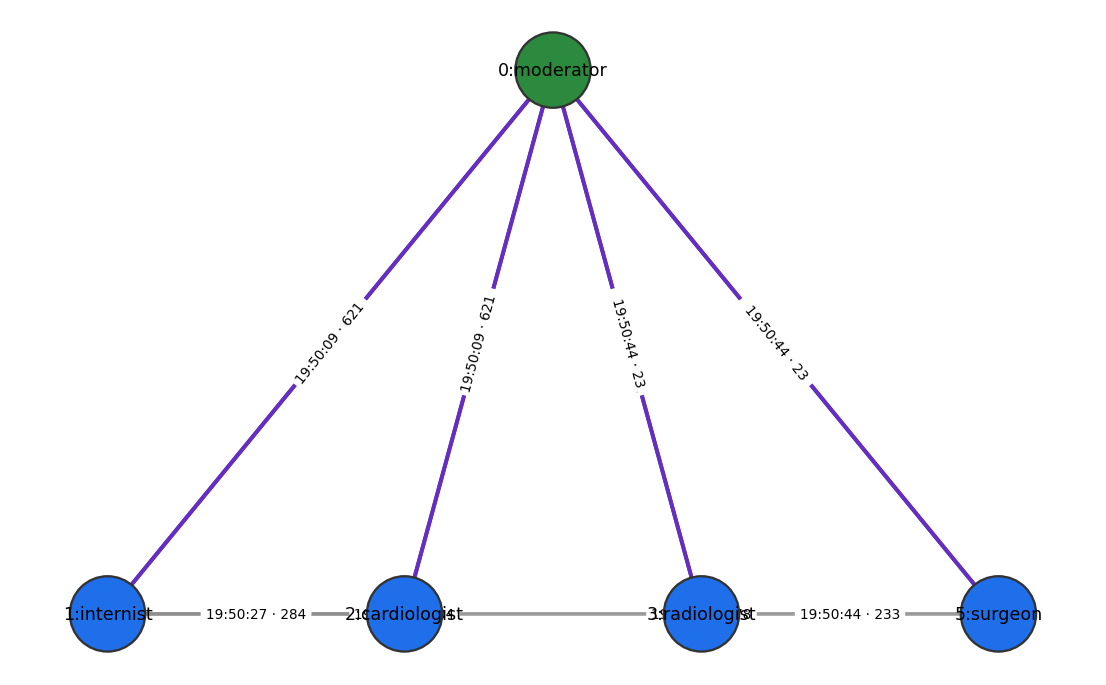

Saved: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_flow.png

Narrative: moderator broadcasted to 4 specialists at 2025-09-12T19:50:09.566482+00:00, last replies arrived by 2025-09-12T19:50:44.728905+00:00.


In [203]:
# === Per-case flow viz + exports ===
import os, math
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timezone
# --- NumPy 2.0 compat shim (for older callers expecting np.alltrue / np.sometrue) ---
import numpy as np
if not hasattr(np, "alltrue"):
    np.alltrue = np.all
if not hasattr(np, "sometrue"):
    np.sometrue = np.any

def iso(t):
    return datetime.fromtimestamp(float(t), tz=timezone.utc).strftime("%H:%M:%S")

def case_edges_nodes(G, case_id):
    nodes = {n: G.nodes[n] for n in G.nodes
             if isinstance(n, tuple) and n[0]==case_id}
    edges = [(u,v,k,d) for u,v,k,d in G.edges(keys=True, data=True)
             if isinstance(u,tuple) and isinstance(v,tuple)
             and u[0]==case_id and v[0]==case_id]
    return nodes, edges

def export_case_tables(G, case_id, out_dir):
    nodes, edges = case_edges_nodes(G, case_id)
    # Nodes table
    nd_rows = []
    for (cid, idx), a in sorted(nodes.items(), key=lambda x: x[0][1]):
        nd_rows.append({
            "case_id": cid,
            "agent_idx": idx,
            "role": a.get("role"),
            "n_msgs": a.get("n_msgs"),
            "out_ratio": a.get("out_ratio"),
            "first_ts": a.get("first_ts"),
            "last_ts": a.get("last_ts"),
            "gpu_util_mean": a.get("gpu_util_mean"),
            "gpu_mem_max": a.get("gpu_mem_max"),
            "http_req_count": a.get("http_req_count"),
            "dns_query_count": a.get("dns_query_count"),
        })
    nodes_df = pd.DataFrame(nd_rows)

    # Edges table (chronological)
    ed_rows = []
    for (u,v,k,d) in edges:
        ed_rows.append({
            "when_utc": datetime.fromtimestamp(float(d.get("end_ts", 0)), tz=timezone.utc).isoformat() if d.get("end_ts") else None,
            "src_idx": u[1],
            "src_role": G.nodes[u].get("role"),
            "dst_idx": v[1],
            "dst_role": G.nodes[v].get("role"),
            "chars": d.get("chars"),
            "prompt_tokens": d.get("prompt_tokens") or 0,
            "completion_tokens": d.get("completion_tokens") or 0,
            "http_count_win": d.get("http_count_win"),
            "dns_count_win": d.get("dns_count_win"),
            "gpu_util_mean_win": d.get("gpu_util_mean_win"),
            "gpu_mem_max_win": d.get("gpu_mem_max_win"),
            "msg_uid": k,
        })
    edges_df = pd.DataFrame(ed_rows).sort_values("when_utc")

    nodes_csv = os.path.join(out_dir, f"{case_id}_nodes.csv")
    edges_csv = os.path.join(out_dir, f"{case_id}_edges.csv")
    nodes_df.to_csv(nodes_csv, index=False)
    edges_df.to_csv(edges_csv, index=False)
    print("Saved:", nodes_csv)
    print("Saved:", edges_csv)
    return nodes_df, edges_df

def draw_case_flow(G, case_id, out_dir):
    nodes, edges = case_edges_nodes(G, case_id)

    # Build a simple DiGraph for drawing
    H = nx.DiGraph()
    for n, a in nodes.items():
        H.add_node(n, **a)
    for (u,v,k,d) in edges:
        H.add_edge(u, v, **d)

    # Layout: moderator on top, specialists on bottom (left→right)
    # Find moderator node (idx 0). If absent, pick the smallest idx as "root".
    mod = next((n for n,a in H.nodes(data=True) if a.get("role")=="moderator"), None)
    if mod is None:
        mod = sorted(H.nodes, key=lambda x: x[1])[0]

    specialists = sorted([n for n in H.nodes if n != mod], key=lambda x: x[1])

    # Coordinates
    pos = {mod: (0.5, 1.0)}
    if specialists:
        xs = [i/(len(specialists)-1) if len(specialists)>1 else 0.5 for i in range(len(specialists))]
        for n, x in zip(specialists, xs):
            pos[n] = (x, 0.0)

    # Edge type classification
    def edge_type(u, v):
        if u == mod and v in specialists: return "broadcast"
        if v == mod and u in specialists: return "return"
        return "peer"

    # Draw
    plt.figure(figsize=(8, 5), dpi=140)
    # Node styles
    node_colors = []
    node_labels = {}
    for n, a in H.nodes(data=True):
        if n == mod:
            node_colors.append("#2b8a3e")  # green
        else:
            node_colors.append("#1f6feb")  # blue
        role = a.get("role") or "agent"
        node_labels[n] = f"{n[1]}:{role}"

    nx.draw_networkx_nodes(H, pos, node_size=1500, node_color=node_colors, linewidths=1.2, edgecolors="#333")
    nx.draw_networkx_labels(H, pos, labels=node_labels, font_size=9)

    # Draw edges in three passes for clean legend
    style = {
        "broadcast": dict(arrows=True, width=2.0, alpha=0.9, edge_color="#222"),
        "return":    dict(arrows=True, width=2.0, alpha=0.9, edge_color="#6c2bd9"),
        "peer":      dict(arrows=True, width=1.8, alpha=0.6, edge_color="#888"),
    }
    for kind in ("broadcast","return","peer"):
        E = [(u,v) for u,v in H.edges() if edge_type(u,v)==kind]
        if E:
            nx.draw_networkx_edges(H, pos, edgelist=E, arrowstyle="-|>", arrowsize=14, **style[kind])

    # Edge labels: hh:mm:ss + chars
    elabels = {}
    for u, v, d in H.edges(data=True):
        t = d.get("end_ts")
        label = (iso(t) if t else "") + (f" · {d.get('chars','')}" if d.get('chars') else "")
        elabels[(u,v)] = label.strip(" ·")
    nx.draw_networkx_edge_labels(H, pos, edge_labels=elabels, font_size=7)

    plt.axis("off")
    png_path = os.path.join(out_dir, f"{case_id}_flow.png")
    plt.tight_layout()
    plt.savefig(png_path, bbox_inches="tight")
    plt.show()
    print("Saved:", png_path)

# === Run it for your chosen case ===
case_id = "c527edd048ab505393b0a804aa531484"  # <- replace if you want a different case
nodes_df, edges_df = export_case_tables(G, case_id, BASE_PATH)
draw_case_flow(G, case_id, BASE_PATH)

# Bonus: quick one-line narrative
last_reply_to_mod = edges_df.loc[edges_df["dst_idx"] == 0, "when_utc"].max()
first_broadcast   = edges_df.loc[edges_df["src_idx"] == 0, "when_utc"].min()
n_broadcasts      = (edges_df["src_idx"] == 0).sum()

last_reply_to_mod = edges_df.loc[edges_df["dst_idx"] == 0, "when_utc"].max()
first_broadcast   = edges_df.loc[edges_df["src_idx"] == 0, "when_utc"].min()
n_broadcasts      = (edges_df["src_idx"] == 0).sum()

print(f"\nNarrative: moderator broadcasted to {n_broadcasts} specialists at {first_broadcast}, "
      f"last replies arrived by {last_reply_to_mod}.")




In [204]:
import os, pickle
out_dir  = BASE_PATH
gpickle  = os.path.join(out_dir, "message_graph.gpickle")
with open(gpickle, "wb") as f:
    pickle.dump(G, f, protocol=pickle.HIGHEST_PROTOCOL)
print("Saved:", gpickle, "nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

# (Optional) also save GraphML for tools that prefer it
try:
    import networkx as nx
    graphml = os.path.join(out_dir, "message_graph.graphml")
    nx.write_graphml(G, graphml)
    print("Saved:", graphml)
except Exception as e:
    print("GraphML export skipped:", e)


Saved: /content/drive/MyDrive/logs_bundle2/message_graph.gpickle nodes: 1095 edges: 2875
GraphML export skipped: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.


In [205]:
from datetime import datetime, timezone
import pandas as pd
import math

def iso(t):
    try:
        return datetime.fromtimestamp(float(t), tz=timezone.utc).isoformat()
    except Exception:
        return None

def pick_one_case_id(G):
    case_ids = {n[0] for n in G.nodes if isinstance(n, tuple)}
    return sorted(case_ids)[0] if case_ids else None

def case_tables(G, case_id=None):
    if case_id is None:
        case_id = pick_one_case_id(G)
    # nodes
    node_rows = []
    for n in sorted([n for n in G.nodes if isinstance(n, tuple) and n[0]==case_id], key=lambda x: x[1]):
        a = G.nodes[n]
        node_rows.append({
            "agent_idx": n[1],
            "role": a.get("role"),
            "n_msgs": a.get("n_msgs"),
            "n_out": a.get("n_out"),
            "out_ratio": a.get("out_ratio"),
            "first_ts": iso(a.get("first_ts")),
            "last_ts":  iso(a.get("last_ts")),
            "http_req_count": a.get("http_req_count"),
            "dns_query_count": a.get("dns_query_count"),
            "gpu_util_mean": a.get("gpu_util_mean"),
            "gpu_util_max": a.get("gpu_util_max"),
            "gpu_mem_max": a.get("gpu_mem_max"),
            "power_w_mean": a.get("power_w_mean"),
        })
    nodes_df = pd.DataFrame(node_rows).sort_values(["role","agent_idx"]).reset_index(drop=True)

    # edges
    edge_rows = []
    for u, v, k, d in G.edges(keys=True, data=True):
        if not (isinstance(u, tuple) and isinstance(v, tuple)):
            continue
        if u[0] != case_id or v[0] != case_id:
            continue
        edge_rows.append({
            "when_utc": iso(d.get("end_ts")),
            "src_idx": u[1],
            "src_role": G.nodes[u].get("role"),
            "dst_idx": v[1],
            "dst_role": G.nodes[v].get("role"),
            "chars": d.get("chars"),
            "prompt_tokens": d.get("prompt_tokens"),
            "completion_tokens": d.get("completion_tokens"),
            "http_count_win": d.get("http_count_win"),
            "dns_count_win": d.get("dns_count_win"),
            "gpu_util_mean_win": d.get("gpu_util_mean_win"),
            "gpu_mem_max_win": d.get("gpu_mem_max_win"),
            "msg_uid": k,
        })
    edges_df = pd.DataFrame(edge_rows).sort_values("when_utc").reset_index(drop=True)
    return case_id, nodes_df, edges_df

# ----- run it
case_id, nodes_df, edges_df = case_tables(G, case_id="c527edd048ab505393b0a804aa531484")  # <— change if you like
nodes_df.head(), edges_df.head()


(   agent_idx          role  n_msgs  n_out  out_ratio  \
 0          2  cardiologist       5      2       0.40   
 1          1     internist       5      2       0.40   
 2          0     moderator       8      4       0.50   
 3          3   radiologist       4      2       0.50   
 4          5       surgeon       4      3       0.75   
 
                            first_ts                           last_ts  \
 0  2025-09-12T19:50:09.576482+00:00  2025-09-12T19:50:39.624126+00:00   
 1  2025-09-12T19:50:09.566482+00:00  2025-09-12T19:50:36.301351+00:00   
 2  2025-09-12T19:50:09.566482+00:00  2025-09-12T19:50:44.728905+00:00   
 3  2025-09-12T19:50:09.586482+00:00  2025-09-12T19:50:44.728905+00:00   
 4  2025-09-12T19:50:09.596482+00:00  2025-09-12T19:50:44.728905+00:00   
 
    http_req_count  dns_query_count  gpu_util_mean  gpu_util_max  gpu_mem_max  \
 0               4                0      51.275862          83.0       6941.0   
 1               4                0      51.4230

In [206]:
nodes_csv = os.path.join(BASE_PATH, f"{case_id}_nodes.csv")
edges_csv = os.path.join(BASE_PATH, f"{case_id}_edges.csv")
nodes_df.to_csv(nodes_csv, index=False)
edges_df.to_csv(edges_csv, index=False)
print("Saved:", nodes_csv)
print("Saved:", edges_csv)


Saved: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_nodes.csv
Saved: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_edges.csv


In [207]:
def summarize_case(nodes_df, edges_df):
    # who is moderator?
    mod_rows = nodes_df[nodes_df["role"]=="moderator"]
    mod = mod_rows.iloc[0].to_dict() if len(mod_rows) else None

    # specialists (everyone else)
    specs = nodes_df[nodes_df["role"]!="moderator"].sort_values("agent_idx")

    # counts
    n_agents = len(nodes_df)
    n_edges  = len(edges_df)
    n_spec   = len(specs)

    print(f"Case overview — agents: {n_agents} (moderator + {n_spec} specialists), edges: {n_edges}")
    if mod:
        print("\nModerator (node 0) activity window:")
        print(f"  first: {mod['first_ts']}")
        print(f"  last : {mod['last_ts']}")
        print(f"  msgs out/in: {int(mod['n_out'])}/{int(mod['n_msgs']) - int(mod['n_out'])} (out_ratio={mod['out_ratio']:.2f})")
        print(f"  http/dns seen (case lifetime): {int(mod['http_req_count'])}/{int(mod['dns_query_count'])}")
        if not (mod.get("gpu_util_mean") is None or (isinstance(mod.get("gpu_util_mean"), float) and math.isnan(mod["gpu_util_mean"]))):
            print(f"  GPU util mean/max: {mod['gpu_util_mean']:.1f}% / {mod['gpu_util_max']:.1f}%")
    else:
        print("No moderator node found (0).")

    print("\nSpecialists:")
    for _, r in specs.iterrows():
        print(f"  {int(r['agent_idx']):>2} : {r['role']:<14} msgs={int(r['n_msgs'])} out_ratio={r['out_ratio']:.2f} "
              f"window=[{r['first_ts']} → {r['last_ts']}]")

    # moderator broadcasts (0 -> *)
    mod_out = edges_df[(edges_df.src_role=="moderator")]
    print("\nModerator kickoff/broadcast messages:")
    if len(mod_out)==0:
        print("  (none)")
    else:
        for _, e in mod_out.sort_values("when_utc").iterrows():
            print(f"  {e['when_utc']}  0:moderator → {int(e['dst_idx'])}:{e['dst_role']}  chars={e['chars']}  "
                  f"http_win={e['http_count_win']} dns_win={e['dns_count_win']}")

    # specialist → moderator returns (* -> 0)
    to_mod = edges_df[(edges_df.dst_role=="moderator")]
    print("\nSpecialists returning final answers to moderator:")
    if len(to_mod)==0:
        print("  (none)")
    else:
        for _, e in to_mod.sort_values("when_utc").iterrows():
            print(f"  {e['when_utc']}  {int(e['src_idx'])}:{e['src_role']} → 0:moderator  chars={e['chars']}  "
                  f"http_win={e['http_count_win']} dns_win={e['dns_count_win']}")

# ----- run it
summarize_case(nodes_df, edges_df)


Case overview — agents: 5 (moderator + 4 specialists), edges: 13

Moderator (node 0) activity window:
  first: 2025-09-12T19:50:09.566482+00:00
  last : 2025-09-12T19:50:44.728905+00:00
  msgs out/in: 4/4 (out_ratio=0.50)
  http/dns seen (case lifetime): 6/0
  GPU util mean/max: 52.2% / 83.0%

Specialists:
   1 : internist      msgs=5 out_ratio=0.40 window=[2025-09-12T19:50:09.566482+00:00 → 2025-09-12T19:50:36.301351+00:00]
   2 : cardiologist   msgs=5 out_ratio=0.40 window=[2025-09-12T19:50:09.576482+00:00 → 2025-09-12T19:50:39.624126+00:00]
   3 : radiologist    msgs=4 out_ratio=0.50 window=[2025-09-12T19:50:09.586482+00:00 → 2025-09-12T19:50:44.728905+00:00]
   5 : surgeon        msgs=4 out_ratio=0.75 window=[2025-09-12T19:50:09.596482+00:00 → 2025-09-12T19:50:44.728905+00:00]

Moderator kickoff/broadcast messages:
  2025-09-12T19:50:09.566482+00:00  0:moderator → 1:internist  chars=621  http_win=0 dns_win=0
  2025-09-12T19:50:09.576482+00:00  0:moderator → 2:cardiologist  chars=62

In [208]:
# NumPy 2.0 compat shim (some libs still call removed aliases)
import numpy as np
if not hasattr(np, "alltrue"):  np.alltrue = np.all
if not hasattr(np, "sometrue"): np.sometrue = np.any

import networkx as nx
import matplotlib.pyplot as plt

def draw_small_flow(edges_df, out_png):
    H = nx.DiGraph()
    # add nodes (moderator first)
    roles = {}
    for _, e in edges_df.iterrows():
        roles[e["src_idx"]] = e["src_role"]
        roles[e["dst_idx"]] = e["dst_role"]
    for idx, role in sorted(roles.items(), key=lambda x: (x[0]!=0, x[0])):
        H.add_node(idx, role=role)

    # add edges in time order
    for _, e in edges_df.sort_values("when_utc").iterrows():
        H.add_edge(int(e["src_idx"]), int(e["dst_idx"]))

    # positions: moderator on top, others bottom line
    pos = {}
    pos[0] = (0.5, 1.0)
    others = [i for i in H.nodes() if i != 0]
    if others:
        xs = np.linspace(0.1, 0.9, len(others))
        for x, i in zip(xs, others):
            pos[i] = (x, 0.0)

    plt.figure(figsize=(8,4.5), dpi=150)
    node_colors = ["#42b883" if n==0 else "#60a5fa" for n in H.nodes()]
    nx.draw(H, pos, with_labels=True, labels={n:f"{n}:{H.nodes[n]['role']}" for n in H.nodes()},
            node_color=node_colors, node_size=1100, arrows=True, width=1.5, font_size=8)
    plt.title(f"Case {case_id} — Moderator & Specialists Flow", fontsize=10)
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close()
    print("Saved flow PNG:", out_png)

flow_png = os.path.join(BASE_PATH, f"{case_id}_flow.png")
draw_small_flow(edges_df, flow_png)


Saved flow PNG: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_flow.png


/tmp/ipython-input-3455130955.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [209]:
import os, pickle
gpickle = os.path.join(BASE_PATH, "message_graph.gpickle")
with open(gpickle, "wb") as f:
    pickle.dump(G, f, protocol=pickle.HIGHEST_PROTOCOL)
print("Saved graph:", gpickle, "nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())


Saved graph: /content/drive/MyDrive/logs_bundle2/message_graph.gpickle nodes: 1095 edges: 2875


In [210]:
from datetime import datetime, timezone
import pandas as pd
import os, math

def _iso(ts):
    try:
        return datetime.fromtimestamp(float(ts), tz=timezone.utc).isoformat()
    except Exception:
        return None

def export_case_full(G, case_id: str, out_dir: str):
    # -------- nodes (all attrs) --------
    node_rows = []
    for n in G.nodes:
        if not (isinstance(n, tuple) and n[0] == case_id):
            continue
        case, agent_idx = n
        attrs = dict(G.nodes[n])  # full attribute dict
        row = {"case_id": case, "agent_idx": agent_idx}
        row.update(attrs)
        # convenience ISO
        if "first_ts" in attrs: row["first_ts_iso"] = _iso(attrs["first_ts"])
        if "last_ts"  in attrs: row["last_ts_iso"]  = _iso(attrs["last_ts"])
        node_rows.append(row)

    nodes_full_df = pd.DataFrame(node_rows).sort_values(["agent_idx"]).reset_index(drop=True)

    # -------- edges (all attrs) --------
    edge_rows = []
    for u, v, k, d in G.edges(keys=True, data=True):
        if not (isinstance(u, tuple) and isinstance(v, tuple)):
            continue
        if u[0] != case_id or v[0] != case_id:
            continue
        row = {
            "case_id": case_id,
            "src_idx": u[1],
            "dst_idx": v[1],
            "edge_key": k,  # msg_uid
        }
        row.update(dict(d))
        # convenience ISO
        if "end_ts" in d:   row["end_ts_iso"]   = _iso(d["end_ts"])
        if "start_ts" in d: row["start_ts_iso"] = _iso(d["start_ts"])
        edge_rows.append(row)

    edges_full_df = pd.DataFrame(edge_rows)

    # ---- FIXED SORT: make temp sort columns, then drop them
    if not edges_full_df.empty:
        edges_full_df["_sort_end"] = pd.to_numeric(edges_full_df.get("end_ts"), errors="coerce")
        edges_full_df["_sort_ts"]  = pd.to_datetime(edges_full_df.get("ts"), utc=True, errors="coerce")
        edges_full_df = edges_full_df.sort_values(
            by=["_sort_end", "_sort_ts"], na_position="last"
        ).drop(columns=["_sort_end", "_sort_ts"]).reset_index(drop=True)

    # -------- write to disk --------
    nodes_csv = os.path.join(out_dir, f"{case_id}_nodes_full.csv")
    edges_csv = os.path.join(out_dir, f"{case_id}_edges_full.csv")
    nodes_full_df.to_csv(nodes_csv, index=False)
    edges_full_df.to_csv(edges_csv, index=False)
    print("Saved:", nodes_csv)
    print("Saved:", edges_csv)
    return nodes_full_df, edges_full_df

# --- timeline & adjacency (unchanged, but included for convenience) ---
def interaction_timeline(G, case_id: str) -> pd.DataFrame:
    rows = []
    for u, v, k, d in G.edges(keys=True, data=True):
        if not (isinstance(u, tuple) and isinstance(v, tuple)):
            continue
        if u[0] != case_id or v[0] != case_id:
            continue
        rows.append({
            "when_utc": _iso(d.get("end_ts")),
            "src": f"{u[1]}:{G.nodes[u].get('role')}",
            "dst": f"{v[1]}:{G.nodes[v].get('role')}",
            "edge_key": k,
            "chars": d.get("chars"),
            "prompt_tokens": d.get("prompt_tokens"),
            "completion_tokens": d.get("completion_tokens"),
            "http_count_win": d.get("http_count_win"),
            "dns_count_win": d.get("dns_count_win"),
            "gpu_util_mean_win": d.get("gpu_util_mean_win"),
            "gpu_mem_max_win": d.get("gpu_mem_max_win"),
        })
    return pd.DataFrame(rows).sort_values("when_utc").reset_index(drop=True)

from collections import defaultdict
def adjacency_summary(G, case_id: str):
    nbrs = defaultdict(set)
    for u, v in G.edges(keys=False):
        if not (isinstance(u, tuple) and isinstance(v, tuple)):
            continue
        if u[0] != case_id or v[0] != case_id:
            continue
        nbrs[u[1]].add(v[1])
    print("Adjacency (agent_idx -> neighbors)")
    for i in sorted(nbrs):
        print(f"  {i} -> {sorted(nbrs[i])}")

# ---- RUN for your case ----
case_id = "c527edd048ab505393b0a804aa531484"  # change if needed
nodes_full_df, edges_full_df = export_case_full(G, case_id, BASE_PATH)
timeline_df = interaction_timeline(G, case_id)
timeline_csv = os.path.join(BASE_PATH, f"{case_id}_timeline.csv")
timeline_df.to_csv(timeline_csv, index=False)
print("Saved:", timeline_csv)

display(nodes_full_df.head(10))
display(edges_full_df.head(10))
display(timeline_df.head(15))
adjacency_summary(G, case_id)

# Optional quick narrative for slides
print(f"\nCase {case_id}: nodes={len(nodes_full_df)} edges={len(edges_full_df)}")
mods = nodes_full_df.query("role=='moderator'")
if not mods.empty:
    m = mods.iloc[0]
    print("Moderator activity:",
          f"{m.get('first_ts_iso')} → {m.get('last_ts_iso')},",
          f"msgs out/in={int(m.get('n_out',0))}/{int(m.get('n_msgs',0)-m.get('n_out',0))},",
          f"http/dns={int(m.get('http_req_count',0))}/{int(m.get('dns_query_count',0))},",
          f"GPU mean/max={m.get('gpu_util_mean'):.1f}%/{m.get('gpu_util_max'):.1f}%")


Saved: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_nodes_full.csv
Saved: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_edges_full.csv
Saved: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_timeline.csv


,case_id,agent_idx,role,n_msgs,n_out,out_ratio,first_ts,last_ts,duration_ms,http_req_count,...,cs_mean,load1_mean,syscalls_total,top_syscall,gpu_util_mean,gpu_util_max,gpu_mem_max,power_w_mean,first_ts_iso,last_ts_iso
0,c527edd048ab505393b0a804aa531484,0,moderator,8,4,0.50,1.757707e+09,1.757707e+09,35162.423372,6,...,2520.028571,NaN,NaN,None,52.176471,83.0,6941.0,121.789118,2025-09-12T19:50:09.566482+00:00,2025-09-12T19:50:44.728905+00:00
1,c527edd048ab505393b0a804aa531484,1,internist,5,2,0.40,1.757707e+09,1.757707e+09,26734.869242,4,...,2396.629630,NaN,NaN,None,51.423077,83.0,6941.0,119.004615,2025-09-12T19:50:09.566482+00:00,2025-09-12T19:50:36.301351+00:00
2,c527edd048ab505393b0a804aa531484,2,cardiologist,5,2,0.40,1.757707e+09,1.757707e+09,30047.644377,4,...,2446.333333,NaN,NaN,None,51.275862,83.0,6941.0,123.005172,2025-09-12T19:50:09.576482+00:00,2025-09-12T19:50:39.624126+00:00
3,c527edd048ab505393b0a804aa531484,3,radiologist,4,2,0.50,1.757707e+09,1.757707e+09,35142.423391,6,...,2520.028571,NaN,NaN,None,52.176471,83.0,6941.0,121.789118,2025-09-12T19:50:09.586482+00:00,2025-09-12T19:50:44.728905+00:00
4,c527edd048ab505393b0a804aa531484,5,surgeon,4,3,0.75,1.757707e+09,1.757707e+09,35132.423401,6,...,2520.028571,NaN,NaN,None,52.176471,83.0,6941.0,121.789118,2025-09-12T19:50:09.596482+00:00,2025-09-12T19:50:44.728905+00:00


,case_id,src_idx,dst_idx,edge_key,ts,round,turn,chars,prompt_tokens,completion_tokens,...,gpu_power_mean_win,gpu_mem_max_win,start_ts,end_ts,message_text,moderator_text,vis_width,vis_length,end_ts_iso,start_ts_iso
0,c527edd048ab505393b0a804aa531484,0,1,94e9aa21c2a32bac02837cf0c6c52cc8,2025-09-12T19:50:09.566482+00:00,1,0,621,0.0,0.0,...,111.840000,6917.0,1.757707e+09,1.757707e+09,<trace:c527edd048ab505393b0a804aa531484> A 45-...,None,1.562462,57.725887,2025-09-12T19:50:09.566482+00:00,2025-09-12T19:50:08.566482+00:00
1,c527edd048ab505393b0a804aa531484,0,2,92768b387619c84d42f12f5d5e68bc59,2025-09-12T19:50:09.576482+00:00,1,0,621,0.0,0.0,...,111.840000,6917.0,1.757707e+09,1.757707e+09,<trace:c527edd048ab505393b0a804aa531484> A 45-...,None,1.562462,57.725887,2025-09-12T19:50:09.576482+00:00,2025-09-12T19:50:08.576482+00:00
2,c527edd048ab505393b0a804aa531484,0,3,0a2ab3dda151760ee877dd2669ffc687,2025-09-12T19:50:09.586482+00:00,1,0,621,0.0,0.0,...,111.840000,6917.0,1.757707e+09,1.757707e+09,<trace:c527edd048ab505393b0a804aa531484> A 45-...,None,1.562462,57.725887,2025-09-12T19:50:09.586482+00:00,2025-09-12T19:50:08.586482+00:00
3,c527edd048ab505393b0a804aa531484,0,5,68fbf9bd796fcfc5f9d81f13145f1a67,2025-09-12T19:50:09.596482+00:00,1,0,621,0.0,0.0,...,111.840000,6917.0,1.757707e+09,1.757707e+09,<trace:c527edd048ab505393b0a804aa531484> A 45-...,None,1.562462,57.725887,2025-09-12T19:50:09.596482+00:00,2025-09-12T19:50:08.596482+00:00
4,c527edd048ab505393b0a804aa531484,2,1,2f30808ca8f87740b1c304d449aa8140,2025-09-12T19:50:27.180839,1,1,284,21.0,65.0,...,138.136667,6849.0,1.757707e+09,1.757707e+09,"Hello, Agent 2! I have received the message fr...",None,2.174081,79.966592,2025-09-12T19:50:27.180839+00:00,2025-09-12T19:50:24.693410+00:00
5,c527edd048ab505393b0a804aa531484,3,1,c51e61c25503777fb6361b9c410255f6,2025-09-12T19:50:30.993256,1,1,304,21.0,64.0,...,116.935000,6849.0,1.757707e+09,1.757707e+09,"Hi Agent 1, could you please provide me with s...",None,2.166964,79.707766,2025-09-12T19:50:30.993256+00:00,2025-09-12T19:50:28.528320+00:00
6,c527edd048ab505393b0a804aa531484,1,2,f4a9120ede317d2b5c87b02be974ad83,2025-09-12T19:50:36.051351,1,1,249,21.0,65.0,...,115.490000,6849.0,1.757707e+09,1.757707e+09,I understand that you are looking for a way to...,None,2.163650,79.587283,2025-09-12T19:50:36.051351+00:00,2025-09-12T19:50:33.596836+00:00
7,c527edd048ab505393b0a804aa531484,1,0,613acebeccbbabd356650228582472f3,2025-09-12T19:50:36.301351+00:00,1,0,23,NaN,NaN,...,100.810000,6847.0,1.757707e+09,1.757707e+09,final: returning answer,None,1.562462,57.725887,2025-09-12T19:50:36.301351+00:00,2025-09-12T19:50:35.301351+00:00
8,c527edd048ab505393b0a804aa531484,5,2,b2375317e33f34fd92db4a042048c13c,2025-09-12T19:50:39.374126,1,1,178,21.0,52.0,...,149.685000,6849.0,1.757707e+09,1.757707e+09,Can you explain why Barrett's esophagus occurs...,None,2.030128,74.731930,2025-09-12T19:50:39.374126+00:00,2025-09-12T19:50:37.314483+00:00
9,c527edd048ab505393b0a804aa531484,2,0,0f02e9023e1a30d1526fce40af3030dc,2025-09-12T19:50:39.624126+00:00,1,0,23,NaN,NaN,...,173.660000,6885.0,1.757707e+09,1.757707e+09,final: returning answer,None,1.562462,57.725887,2025-09-12T19:50:39.624126+00:00,2025-09-12T19:50:38.624126+00:00


,when_utc,src,dst,edge_key,chars,prompt_tokens,completion_tokens,http_count_win,dns_count_win,gpu_util_mean_win,gpu_mem_max_win
0,2025-09-12T19:50:09.566482+00:00,0:moderator,1:internist,94e9aa21c2a32bac02837cf0c6c52cc8,621,0.0,0.0,0,0,45.0,6917.0
1,2025-09-12T19:50:09.576482+00:00,0:moderator,2:cardiologist,92768b387619c84d42f12f5d5e68bc59,621,0.0,0.0,0,0,45.0,6917.0
2,2025-09-12T19:50:09.586482+00:00,0:moderator,3:radiologist,0a2ab3dda151760ee877dd2669ffc687,621,0.0,0.0,0,0,45.0,6917.0
3,2025-09-12T19:50:09.596482+00:00,0:moderator,5:surgeon,68fbf9bd796fcfc5f9d81f13145f1a67,621,0.0,0.0,0,0,45.0,6917.0
4,2025-09-12T19:50:27.180839+00:00,2:cardiologist,1:internist,2f30808ca8f87740b1c304d449aa8140,284,21.0,65.0,0,0,50.0,6849.0
5,2025-09-12T19:50:30.993256+00:00,3:radiologist,1:internist,c51e61c25503777fb6361b9c410255f6,304,21.0,64.0,0,0,49.0,6849.0
6,2025-09-12T19:50:36.051351+00:00,1:internist,2:cardiologist,f4a9120ede317d2b5c87b02be974ad83,249,21.0,65.0,0,0,48.0,6849.0
7,2025-09-12T19:50:36.301351+00:00,1:internist,0:moderator,613acebeccbbabd356650228582472f3,23,NaN,NaN,0,0,78.0,6847.0
8,2025-09-12T19:50:39.374126+00:00,5:surgeon,2:cardiologist,b2375317e33f34fd92db4a042048c13c,178,21.0,52.0,0,0,48.0,6849.0
9,2025-09-12T19:50:39.624126+00:00,2:cardiologist,0:moderator,0f02e9023e1a30d1526fce40af3030dc,23,NaN,NaN,0,0,54.0,6885.0


Adjacency (agent_idx -> neighbors)
  0 -> [1, 2, 3, 5]
  1 -> [0, 2]
  2 -> [0, 1]
  3 -> [0, 1]
  5 -> [0, 2, 3]

Case c527edd048ab505393b0a804aa531484: nodes=5 edges=13
Moderator activity: 2025-09-12T19:50:09.566482+00:00 → 2025-09-12T19:50:44.728905+00:00, msgs out/in=4/4, http/dns=6/0, GPU mean/max=52.2%/83.0%


In [211]:
import os, math
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime, timezone

# ---------- helpers ----------
def iso(ts):
    try: return datetime.fromtimestamp(float(ts), tz=timezone.utc).isoformat()
    except: return None

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def _role(n):
    return G.nodes[n].get("role", "?")

def _label(n):
    return f"{n[1]}:{_role(n)}"

def _within_case(u, v, cid):
    return isinstance(u, tuple) and isinstance(v, tuple) and u[0]==cid and v[0]==cid

# ---------- choose your case ----------
case_id = "c527edd048ab505393b0a804aa531484"  # <- change if needed
report_dir = ensure_dir(os.path.join(BASE_PATH, f"{case_id}_report"))

# Load your full tables (already created earlier)
nodes_csv = os.path.join(BASE_PATH, f"{case_id}_nodes_full.csv")
edges_csv = os.path.join(BASE_PATH, f"{case_id}_edges_full.csv")
timeline_csv = os.path.join(BASE_PATH, f"{case_id}_timeline.csv")

nodes_df = pd.read_csv(nodes_csv)
edges_df = pd.read_csv(edges_csv)
timeline_df = pd.read_csv(timeline_csv)

# ---------- 1) Moderator-focused table ----------
mods = nodes_df.query("role=='moderator'")
if not mods.empty:
    mod_idx = int(mods.iloc[0]["agent_idx"])
else:
    # fallback: assume 0
    mod_idx = 0

mod_edges = edges_df.query("(src_idx==@mod_idx) | (dst_idx==@mod_idx)").copy()
mod_edges = mod_edges.sort_values(["end_ts"]).reset_index(drop=True)
mod_edges_path = os.path.join(report_dir, "moderator_edges.csv")
mod_edges.to_csv(mod_edges_path, index=False)

# ---------- 2) Network diagram (PNG) ----------
H = nx.MultiDiGraph()
for n in G.nodes:
    if isinstance(n, tuple) and n[0]==case_id:
        H.add_node(n, **G.nodes[n])

for u, v, k, d in G.edges(keys=True, data=True):
    if _within_case(u, v, case_id):
        H.add_edge(u, v, key=k, **d)

plt.figure(figsize=(8, 6), dpi=150)
# layout: group moderator center-ish
pos = nx.spring_layout(H, seed=7, k=0.6)

# nodes by role
mods_nodes = [n for n in H.nodes if H.nodes[n].get("role")=="moderator"]
spec_nodes = [n for n in H.nodes if H.nodes[n].get("role")!="moderator"]

nx.draw_networkx_nodes(H, pos, nodelist=mods_nodes, node_size=900, node_shape="s")
nx.draw_networkx_nodes(H, pos, nodelist=spec_nodes, node_size=700, node_shape="o")
nx.draw_networkx_labels(H, pos, labels={n:_label(n) for n in H.nodes}, font_size=8)

# light edges first, then heavier “moderator edges” bold
nx.draw_networkx_edges(H, pos, alpha=0.3, arrows=True, arrowsize=10, width=1.0)

mod_u_edges = [(u,v) for u,v in H.edges() if (u[1]==mod_idx or v[1]==mod_idx)]
nx.draw_networkx_edges(H, pos, edgelist=mod_u_edges, alpha=0.9, arrows=True, arrowsize=10, width=2.0)

plt.title(f"Case {case_id} — Conversation Graph")
plt.axis("off")
net_png = os.path.join(report_dir, "network.png")
plt.tight_layout()
plt.savefig(net_png, bbox_inches="tight")
plt.close()

# ---------- 3) Timeline “Gantt” by agent ----------

# ---------- 3) Timeline “Gantt” by agent (fixed) ----------
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

# build order: moderator first, then specialists by agent_idx
order = (
    nodes_df
      .assign(is_mod = nodes_df["role"].eq("moderator").astype(int))  # 1 if mod, 0 if not? we want mod first -> sort by is_mod ascending with True first
      .assign(is_mod = (~nodes_df["role"].eq("moderator")).astype(int))  # make moderator rank 0, specialists 1
      .sort_values(["is_mod","agent_idx"])
      .drop(columns=["is_mod"])
      .reset_index(drop=True)
)

order_map = {int(r.agent_idx): i for i, r in enumerate(order.itertuples())}

# map sender -> y row
plot_df = edges_df.copy()
plot_df["y"] = plot_df["src_idx"].map(order_map)
plot_df = plot_df.dropna(subset=["y"]).copy()
plot_df["y"] = plot_df["y"].astype(int)

# pick timestamps (prefer end_ts_iso if present)
if "end_ts_iso" in plot_df.columns and plot_df["end_ts_iso"].notna().any():
    xs = pd.to_datetime(plot_df["end_ts_iso"], utc=True, errors="coerce")
else:
    xs = pd.to_datetime(plot_df["ts"], utc=True, errors="coerce")

ys = plot_df["y"].to_numpy()

plt.figure(figsize=(10, 4), dpi=150)
plt.scatter(xs, ys, s=18)

plt.yticks(
    range(len(order_map)),
    [f"{int(r.agent_idx)}:{r.role}" for r in order.itertuples()],
    fontsize=8
)

ax = plt.gca()
locator = AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(ConciseDateFormatter(locator))

plt.xlabel("UTC time")
plt.title(f"Case {case_id} — Interaction Timeline (by sender)")
plt.grid(True, axis="x", alpha=0.25)
timeline_png = os.path.join(report_dir, "timeline.png")
plt.tight_layout()
plt.savefig(timeline_png, bbox_inches="tight")
plt.close()

print("Saved timeline:", timeline_png)
# ---------- 4) One-page text summary (markdown) ----------
def md(s): return os.path.join(report_dir, s)

def _fmt(t):
    try:
        return pd.to_datetime(t, utc=True).isoformat()
    except:
        try: return iso(t)
        except: return str(t)

mods_row = mods.iloc[0] if not mods.empty else None
with open(md("README.md"), "w") as f:
    f.write(f"# Case {case_id} summary\n\n")
    f.write(f"- Nodes: **{len(nodes_df)}**  |  Edges: **{len(edges_df)}**\n\n")
    if mods_row is not None:
        f.write("## Moderator\n")
        f.write(f"- idx: **{mod_idx}**  role: **moderator**\n")
        f.write(f"- active: **{mods_row['first_ts_iso']} → {mods_row['last_ts_iso']}**\n")
        f.write(f"- msgs out/in: **{int(mods_row['n_out'])}/{int(mods_row['n_msgs']-mods_row['n_out'])}**  "
                f"(out_ratio={mods_row['out_ratio']:.2f})\n")
        f.write(f"- http/dns seen: **{int(mods_row['http_req_count'])}/{int(mods_row['dns_query_count'])}**\n")
        if pd.notna(mods_row.get("gpu_util_mean", float("nan"))):
            f.write(f"- GPU util mean/max: **{mods_row['gpu_util_mean']:.1f}% / {mods_row['gpu_util_max']:.1f}%**\n")
        f.write("\n")

    f.write("## Specialists\n")
    for r in nodes_df.query("role!='moderator'").sort_values("agent_idx").itertuples():
        f.write(f"- {int(r.agent_idx)} : {r.role:14s}  "
                f"msgs={int(r.n_msgs)}  out_ratio={r.out_ratio:.2f}  "
                f"window=[{r.first_ts_iso} → {r.last_ts_iso}]\n")
    f.write("\n")

    f.write("## Moderator kickoff\n")
    kicks = edges_df.query("src_idx==@mod_idx").sort_values("end_ts")
    for r in kicks.itertuples():
        f.write(f"- {_fmt(r.end_ts_iso)}  {mod_idx}:moderator → {int(r.dst_idx)}  "
                f"chars={int(r.chars) if pd.notna(r.chars) else 'NA'}  "
                f"http_win={int(r.http_count_win)} dns_win={int(r.dns_count_win)}\n")
    f.write("\n")

    f.write("## Finals back to moderator\n")
    finals = edges_df.query("dst_idx==@mod_idx").sort_values("end_ts")
    for r in finals.itertuples():
        f.write(f"- {_fmt(r.end_ts_iso)}  {int(r.src_idx)} → {mod_idx}:moderator  "
                f"chars={int(r.chars) if pd.notna(r.chars) else 'NA'}  "
                f"http_win={int(r.http_count_win)} dns_win={int(r.dns_count_win)}\n")
    f.write("\n")

print("Report folder:", report_dir)
print("├─ README.md")
print("├─ network.png")
print("├─ timeline.png")
print("├─ moderator_edges.csv")
print("├─ (plus your *_nodes_full.csv, *_edges_full.csv, *_timeline.csv in BASE_PATH)")


Saved timeline: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_report/timeline.png
Report folder: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_report
├─ README.md
├─ network.png
├─ timeline.png
├─ moderator_edges.csv
├─ (plus your *_nodes_full.csv, *_edges_full.csv, *_timeline.csv in BASE_PATH)


In [212]:
import pandas as pd

base = "/content/drive/MyDrive/logs_bundle2"
cid  = "c527edd048ab505393b0a804aa531484"

nodes_full = pd.read_csv(f"{base}/{cid}_nodes_full.csv")
edges_full = pd.read_csv(f"{base}/{cid}_edges_full.csv")
timeline   = pd.read_csv(f"{base}/{cid}_timeline.csv")

# Peek
display(nodes_full)
display(edges_full)
display(timeline)


,case_id,agent_idx,role,n_msgs,n_out,out_ratio,first_ts,last_ts,duration_ms,http_req_count,...,cs_mean,load1_mean,syscalls_total,top_syscall,gpu_util_mean,gpu_util_max,gpu_mem_max,power_w_mean,first_ts_iso,last_ts_iso
0,c527edd048ab505393b0a804aa531484,0,moderator,8,4,0.50,1.757707e+09,1.757707e+09,35162.423372,6,...,2520.028571,NaN,NaN,NaN,52.176471,83.0,6941.0,121.789118,2025-09-12T19:50:09.566482+00:00,2025-09-12T19:50:44.728905+00:00
1,c527edd048ab505393b0a804aa531484,1,internist,5,2,0.40,1.757707e+09,1.757707e+09,26734.869242,4,...,2396.629630,NaN,NaN,NaN,51.423077,83.0,6941.0,119.004615,2025-09-12T19:50:09.566482+00:00,2025-09-12T19:50:36.301351+00:00
2,c527edd048ab505393b0a804aa531484,2,cardiologist,5,2,0.40,1.757707e+09,1.757707e+09,30047.644377,4,...,2446.333333,NaN,NaN,NaN,51.275862,83.0,6941.0,123.005172,2025-09-12T19:50:09.576482+00:00,2025-09-12T19:50:39.624126+00:00
3,c527edd048ab505393b0a804aa531484,3,radiologist,4,2,0.50,1.757707e+09,1.757707e+09,35142.423391,6,...,2520.028571,NaN,NaN,NaN,52.176471,83.0,6941.0,121.789118,2025-09-12T19:50:09.586482+00:00,2025-09-12T19:50:44.728905+00:00
4,c527edd048ab505393b0a804aa531484,5,surgeon,4,3,0.75,1.757707e+09,1.757707e+09,35132.423401,6,...,2520.028571,NaN,NaN,NaN,52.176471,83.0,6941.0,121.789118,2025-09-12T19:50:09.596482+00:00,2025-09-12T19:50:44.728905+00:00


,case_id,src_idx,dst_idx,edge_key,ts,round,turn,chars,prompt_tokens,completion_tokens,...,gpu_power_mean_win,gpu_mem_max_win,start_ts,end_ts,message_text,moderator_text,vis_width,vis_length,end_ts_iso,start_ts_iso
0,c527edd048ab505393b0a804aa531484,0,1,94e9aa21c2a32bac02837cf0c6c52cc8,2025-09-12T19:50:09.566482+00:00,1,0,621,0.0,0.0,...,111.840000,6917.0,1.757707e+09,1.757707e+09,<trace:c527edd048ab505393b0a804aa531484> A 45-...,NaN,1.562462,57.725887,2025-09-12T19:50:09.566482+00:00,2025-09-12T19:50:08.566482+00:00
1,c527edd048ab505393b0a804aa531484,0,2,92768b387619c84d42f12f5d5e68bc59,2025-09-12T19:50:09.576482+00:00,1,0,621,0.0,0.0,...,111.840000,6917.0,1.757707e+09,1.757707e+09,<trace:c527edd048ab505393b0a804aa531484> A 45-...,NaN,1.562462,57.725887,2025-09-12T19:50:09.576482+00:00,2025-09-12T19:50:08.576482+00:00
2,c527edd048ab505393b0a804aa531484,0,3,0a2ab3dda151760ee877dd2669ffc687,2025-09-12T19:50:09.586482+00:00,1,0,621,0.0,0.0,...,111.840000,6917.0,1.757707e+09,1.757707e+09,<trace:c527edd048ab505393b0a804aa531484> A 45-...,NaN,1.562462,57.725887,2025-09-12T19:50:09.586482+00:00,2025-09-12T19:50:08.586482+00:00
3,c527edd048ab505393b0a804aa531484,0,5,68fbf9bd796fcfc5f9d81f13145f1a67,2025-09-12T19:50:09.596482+00:00,1,0,621,0.0,0.0,...,111.840000,6917.0,1.757707e+09,1.757707e+09,<trace:c527edd048ab505393b0a804aa531484> A 45-...,NaN,1.562462,57.725887,2025-09-12T19:50:09.596482+00:00,2025-09-12T19:50:08.596482+00:00
4,c527edd048ab505393b0a804aa531484,2,1,2f30808ca8f87740b1c304d449aa8140,2025-09-12T19:50:27.180839,1,1,284,21.0,65.0,...,138.136667,6849.0,1.757707e+09,1.757707e+09,"Hello, Agent 2! I have received the message fr...",NaN,2.174081,79.966592,2025-09-12T19:50:27.180839+00:00,2025-09-12T19:50:24.693410+00:00
5,c527edd048ab505393b0a804aa531484,3,1,c51e61c25503777fb6361b9c410255f6,2025-09-12T19:50:30.993256,1,1,304,21.0,64.0,...,116.935000,6849.0,1.757707e+09,1.757707e+09,"Hi Agent 1, could you please provide me with s...",NaN,2.166964,79.707766,2025-09-12T19:50:30.993256+00:00,2025-09-12T19:50:28.528320+00:00
6,c527edd048ab505393b0a804aa531484,1,2,f4a9120ede317d2b5c87b02be974ad83,2025-09-12T19:50:36.051351,1,1,249,21.0,65.0,...,115.490000,6849.0,1.757707e+09,1.757707e+09,I understand that you are looking for a way to...,NaN,2.163650,79.587283,2025-09-12T19:50:36.051351+00:00,2025-09-12T19:50:33.596836+00:00
7,c527edd048ab505393b0a804aa531484,1,0,613acebeccbbabd356650228582472f3,2025-09-12T19:50:36.301351+00:00,1,0,23,NaN,NaN,...,100.810000,6847.0,1.757707e+09,1.757707e+09,final: returning answer,NaN,1.562462,57.725887,2025-09-12T19:50:36.301351+00:00,2025-09-12T19:50:35.301351+00:00
8,c527edd048ab505393b0a804aa531484,5,2,b2375317e33f34fd92db4a042048c13c,2025-09-12T19:50:39.374126,1,1,178,21.0,52.0,...,149.685000,6849.0,1.757707e+09,1.757707e+09,Can you explain why Barrett's esophagus occurs...,NaN,2.030128,74.731930,2025-09-12T19:50:39.374126+00:00,2025-09-12T19:50:37.314483+00:00
9,c527edd048ab505393b0a804aa531484,2,0,0f02e9023e1a30d1526fce40af3030dc,2025-09-12T19:50:39.624126+00:00,1,0,23,NaN,NaN,...,173.660000,6885.0,1.757707e+09,1.757707e+09,final: returning answer,NaN,1.562462,57.725887,2025-09-12T19:50:39.624126+00:00,2025-09-12T19:50:38.624126+00:00


,when_utc,src,dst,edge_key,chars,prompt_tokens,completion_tokens,http_count_win,dns_count_win,gpu_util_mean_win,gpu_mem_max_win
0,2025-09-12T19:50:09.566482+00:00,0:moderator,1:internist,94e9aa21c2a32bac02837cf0c6c52cc8,621,0.0,0.0,0,0,45.0,6917.0
1,2025-09-12T19:50:09.576482+00:00,0:moderator,2:cardiologist,92768b387619c84d42f12f5d5e68bc59,621,0.0,0.0,0,0,45.0,6917.0
2,2025-09-12T19:50:09.586482+00:00,0:moderator,3:radiologist,0a2ab3dda151760ee877dd2669ffc687,621,0.0,0.0,0,0,45.0,6917.0
3,2025-09-12T19:50:09.596482+00:00,0:moderator,5:surgeon,68fbf9bd796fcfc5f9d81f13145f1a67,621,0.0,0.0,0,0,45.0,6917.0
4,2025-09-12T19:50:27.180839+00:00,2:cardiologist,1:internist,2f30808ca8f87740b1c304d449aa8140,284,21.0,65.0,0,0,50.0,6849.0
5,2025-09-12T19:50:30.993256+00:00,3:radiologist,1:internist,c51e61c25503777fb6361b9c410255f6,304,21.0,64.0,0,0,49.0,6849.0
6,2025-09-12T19:50:36.051351+00:00,1:internist,2:cardiologist,f4a9120ede317d2b5c87b02be974ad83,249,21.0,65.0,0,0,48.0,6849.0
7,2025-09-12T19:50:36.301351+00:00,1:internist,0:moderator,613acebeccbbabd356650228582472f3,23,NaN,NaN,0,0,78.0,6847.0
8,2025-09-12T19:50:39.374126+00:00,5:surgeon,2:cardiologist,b2375317e33f34fd92db4a042048c13c,178,21.0,52.0,0,0,48.0,6849.0
9,2025-09-12T19:50:39.624126+00:00,2:cardiologist,0:moderator,0f02e9023e1a30d1526fce40af3030dc,23,NaN,NaN,0,0,54.0,6885.0


In [213]:
import os, re, glob, networkx as nx
from pathlib import Path

BASE_PATH = '/content/drive/MyDrive/logs_bundle2'
EXP = Path(BASE_PATH) / "_exports"

# 1) All case_ids on disk (from q_* folders)
def extract_case_id(name: str) -> str:
    m = re.search(r'trace_([0-9a-f]+)', name)
    return m.group(1) if m else name

case_dirs = [d for d in os.listdir(BASE_PATH) if d.startswith("q_") and os.path.isdir(os.path.join(BASE_PATH, d))]
all_case_ids = sorted(extract_case_id(d) for d in case_dirs)
print("case folders:", len(all_case_ids))

# 2) All per-case graphs saved (.gpickle)
saved_gps = sorted(Path(p).stem for p in glob.glob(str(EXP / "*.gpickle")))
print("saved per-case graphs:", len(saved_gps))

# 3) What’s missing?
missing = sorted(set(all_case_ids) - set(saved_gps))
print("missing:", len(missing))
if missing:
    print(missing[:20], "… (showing up to 20)")


case folders: 222
saved per-case graphs: 219
missing: 4
['628a7170cc16da529d03243b1f3bb1ee', '7a7753a3d94c07c52a66af37859ec356', '812cadb4d795dcded31a4cf5e997033f', 'e04428e8802bbcd5b4ff6cf353247bfc'] … (showing up to 20)


In [214]:
from pathlib import Path

base = Path(BASE_PATH) / "_exports"
gpks = sorted(p for p in base.glob("*.gpickle") if p.name != "message_graph.gpickle")
jsons = sorted(base.glob("*.json"))
print("per-case gpickles:", len(gpks))
print("per-case jsons   :", len(jsons))

# Show any case directories that didn't get an export
case_dirs = {extract_case_id(p) for p in list_case_dirs(BASE_PATH)}
exported = {p.stem for p in gpks}
missing = sorted(case_dirs - exported)
print("expected cases:", len(case_dirs))
print("exported cases:", len(exported))
print("missing cases :", len(missing))
if missing: print(missing[:10], "...")  # peek


per-case gpickles: 218
per-case jsons   : 218
expected cases: 222
exported cases: 218
missing cases : 4
['628a7170cc16da529d03243b1f3bb1ee', '7a7753a3d94c07c52a66af37859ec356', '812cadb4d795dcded31a4cf5e997033f', 'e04428e8802bbcd5b4ff6cf353247bfc'] ...


In [215]:
from pathlib import Path

def diagnose_missing_cases(G, base_path):
    case_dirs = {extract_case_id(p) for p in list_case_dirs(base_path)}
    export_dir = Path(base_path) / "_exports"
    exported = {p.stem for p in export_dir.glob("*.gpickle") if p.name != "message_graph.gpickle"}

    missing = sorted(case_dirs - exported)
    print("Missing:", len(missing), missing)

    for cid in missing:
        # did we create any nodes/edges for this case?
        nodes = [n for n in G.nodes if isinstance(n, tuple) and n[0]==cid]
        edges = [(u,v) for u,v in G.edges() if isinstance(u,tuple) and isinstance(v,tuple) and u[0]==cid and v[0]==cid]
        print(f"\n== {cid} ==")
        print(" nodes:", len(nodes), "edges:", len(edges))

        # check raw files in that case folder
        case_dir = [d for d in list_case_dirs(base_path) if extract_case_id(d)==cid]
        case_dir = case_dir[0] if case_dir else None
        if not case_dir:
            print("  (No directory found for case id?)")
            continue

        agent_files = list_agent_files(case_dir)
        print(" agent files:", len(agent_files))
        if not agent_files:
            print("  → No agent jsonl files")
            continue

        # count edge_messages with a usable ts
        n_msgs = 0
        n_with_ts = 0
        for ap in agent_files:
            for obj in read_jsonl(ap):
                if obj.get("type")=="edge_message":
                    n_msgs += 1
                    if parse_ts_to_epoch(obj.get("ts")) is not None:
                        n_with_ts += 1
        print(f" edge_messages: {n_msgs}, with timestamps: {n_with_ts}")
        if n_msgs and not n_with_ts:
            print("  → Messages exist but timestamps are missing/invalid, so nodes/edges weren’t built.")
        elif n_msgs==0:
            print("  → No edge_message entries in these jsonl files.")

diagnose_missing_cases(G, BASE_PATH)


Missing: 4 ['628a7170cc16da529d03243b1f3bb1ee', '7a7753a3d94c07c52a66af37859ec356', '812cadb4d795dcded31a4cf5e997033f', 'e04428e8802bbcd5b4ff6cf353247bfc']

== 628a7170cc16da529d03243b1f3bb1ee ==
 nodes: 0 edges: 0
 agent files: 1
 edge_messages: 0, with timestamps: 0
  → No edge_message entries in these jsonl files.

== 7a7753a3d94c07c52a66af37859ec356 ==
 nodes: 0 edges: 0
 agent files: 1
 edge_messages: 0, with timestamps: 0
  → No edge_message entries in these jsonl files.

== 812cadb4d795dcded31a4cf5e997033f ==
 nodes: 0 edges: 0
 agent files: 2
 edge_messages: 0, with timestamps: 0
  → No edge_message entries in these jsonl files.

== e04428e8802bbcd5b4ff6cf353247bfc ==
 nodes: 0 edges: 0
 agent files: 2
 edge_messages: 0, with timestamps: 0
  → No edge_message entries in these jsonl files.


In [216]:
import numpy as np
def check_vis_scaling(G):
    samples = []
    for u,v,k,d in G.edges(keys=True, data=True):
        if "vis_length" in d and d.get("timing_ms") is not None:
            samples.append((d["timing_ms"], d["vis_length"]))
    samples = sorted(samples)[:50]  # small sample
    print("sample (timing_ms -> vis_length):", samples[:5])
    corr = np.corrcoef([s[0] for s in samples], [s[1] for s in samples])[0,1] if len(samples)>2 else None
    print("correlation(timing_ms, vis_length):", corr)
check_vis_scaling(G)


sample (timing_ms -> vis_length): [(154.112, 57.725887222397816), (158.162, 57.725887222397816), (167.151, 57.725887222397816), (187.301, 57.725887222397816), (193.728, 57.725887222397816)]
correlation(timing_ms, vis_length): 2.8362140890066074e-17


In [217]:
#a tidy finish: Build a per-case index (quick dashboard CSV)

In [218]:
from collections import defaultdict
import pandas as pd, math, os

rows = []
case_ids = sorted({n[0] for n in G.nodes if isinstance(n, tuple)})
for cid in case_ids:
    nodes = [(n,a) for n,a in G.nodes(data=True) if isinstance(n, tuple) and n[0]==cid]
    edges = [(u,v,d) for u,v,_,d in G.edges(keys=True, data=True)
             if isinstance(u,tuple) and isinstance(v,tuple) and u[0]==cid and v[0]==cid]
    n_agents = len(nodes)
    n_edges  = len(edges)
    t0s = [a.get("first_ts") for _,a in nodes if a.get("first_ts") is not None]
    t1s = [a.get("last_ts")  for _,a in nodes if a.get("last_ts")  is not None]
    t0 = min(t0s) if t0s else None
    t1 = max(t1s) if t1s else None
    n_specs = sum(1 for _,a in nodes if a.get("role")!="moderator")
    rows.append({"case_id": cid, "agents": n_agents, "specialists": n_specs, "edges": n_edges,
                 "first_ts": t0, "last_ts": t1})
index_df = pd.DataFrame(rows).sort_values("first_ts")
index_csv = os.path.join(BASE_PATH, "_exports", "cases_index.csv")
os.makedirs(os.path.dirname(index_csv), exist_ok=True)
index_df.to_csv(index_csv, index=False)
print("Wrote:", index_csv)


Wrote: /content/drive/MyDrive/logs_bundle2/_exports/cases_index.csv


In [219]:
#One callable to export a whole case packet

Saved: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_nodes_full.csv
Saved: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_edges_full.csv
Saved: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_nodes.csv
Saved: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_edges.csv


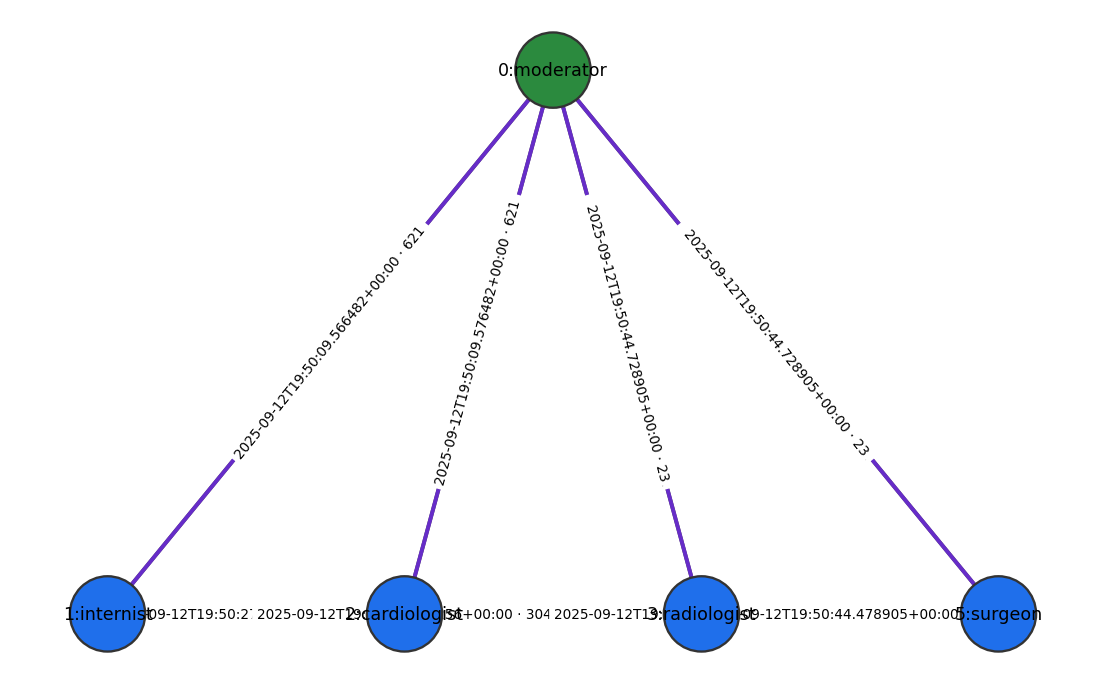

Saved: /content/drive/MyDrive/logs_bundle2/c527edd048ab505393b0a804aa531484_flow.png


(                            case_id  agent_idx          role  n_msgs  n_out  \
 0  c527edd048ab505393b0a804aa531484          0     moderator       8      4   
 1  c527edd048ab505393b0a804aa531484          1     internist       5      2   
 2  c527edd048ab505393b0a804aa531484          2  cardiologist       5      2   
 3  c527edd048ab505393b0a804aa531484          3   radiologist       4      2   
 4  c527edd048ab505393b0a804aa531484          5       surgeon       4      3   
 
    out_ratio      first_ts       last_ts   duration_ms  http_req_count  ...  \
 0       0.50  1.757707e+09  1.757707e+09  35162.423372               6  ...   
 1       0.40  1.757707e+09  1.757707e+09  26734.869242               4  ...   
 2       0.40  1.757707e+09  1.757707e+09  30047.644377               4  ...   
 3       0.50  1.757707e+09  1.757707e+09  35142.423391               6  ...   
 4       0.75  1.757707e+09  1.757707e+09  35132.423401               6  ...   
 
        cs_mean  load1_mean  syscall

In [220]:
def export_case_packet(G, case_id, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    # full nodes/edges + timeline
    nodes_full_df, edges_full_df = export_case_full(G, case_id, out_dir)
    timeline_df = interaction_timeline(G, case_id)
    timeline_df.to_csv(os.path.join(out_dir, f"{case_id}_timeline.csv"), index=False)
    # compact CSVs for analysts
    export_case_tables(G, case_id, out_dir)
    # small flow diagram
    draw_case_flow(G, case_id, out_dir)
    # per-case gpickle/json were already handled in export_per_case_graphs(G, BASE_PATH)
    return nodes_full_df, edges_full_df, timeline_df

# Example:
export_case_packet(G, "c527edd048ab505393b0a804aa531484", BASE_PATH)


In [221]:
print("Graph:", G.number_of_nodes(), "nodes;", G.number_of_edges(), "edges")

# GPU/CPU coverage
import math
edge_gpu_ok = sum(1 for *_,d in G.edges(keys=True, data=True) if not (d.get("gpu_util_mean_win") is None or math.isnan(d.get("gpu_util_mean_win", float('nan')))))
node_gpu_ok = sum(1 for _,a in G.nodes(data=True) if not (a.get("gpu_util_mean") is None or math.isnan(a.get("gpu_util_mean", float('nan')))))
node_cpu_ok = sum(1 for _,a in G.nodes(data=True) if not (a.get("us_mean") is None or math.isnan(a.get("us_mean", float('nan')))))
print(f"edges with GPU win: {edge_gpu_ok}/{G.number_of_edges()} | nodes GPU: {node_gpu_ok}/{G.number_of_nodes()} | nodes CPU: {node_cpu_ok}/{G.number_of_nodes()}")


Graph: 1095 nodes; 2875 edges
edges with GPU win: 2794/2875 | nodes GPU: 1095/1095 | nodes CPU: 1095/1095


In [222]:
from datetime import datetime, timezone
def iso(t):
    return datetime.fromtimestamp(float(t), tz=timezone.utc).isoformat() if t is not None else None

def case_narrative(G, case_id):
    edges_df = pd.read_csv(os.path.join(BASE_PATH, f"{case_id}_edges.csv"))
    first_broadcast = edges_df.loc[edges_df["src_role"]=="moderator","when_utc"].min()
    last_reply      = edges_df.loc[edges_df["dst_role"]=="moderator","when_utc"].max()
    n_fanouts       = (edges_df["src_role"]=="moderator").sum()
    return f"Case {case_id}: moderator broadcasted to {n_fanouts} specialists at {first_broadcast}, last replies by {last_reply}."

print(case_narrative(G, "c527edd048ab505393b0a804aa531484"))


Case c527edd048ab505393b0a804aa531484: moderator broadcasted to 4 specialists at 2025-09-12T19:50:09.566482+00:00, last replies by 2025-09-12T19:50:44.728905+00:00.


In [223]:
from pathlib import Path
exp = Path(BASE_PATH) / "_exports"

gpks = sorted(exp.glob("*.gpickle"))
jsons = sorted(exp.glob("*.json"))

print("Per-case gpickles:", len(gpks))
print("Per-case jsons   :", len(jsons))
print("Unified gpickle exists?:", (exp / "message_graph.gpickle").exists())

print("Example files:")
for p in gpks[:5]:
    print(" -", p.name)


Per-case gpickles: 219
Per-case jsons   : 218
Unified gpickle exists?: True
Example files:
 - 000440c537d61c098a47772d5377eaf8.gpickle
 - 00eb431115d51fec42f4d6cb4ec50361.gpickle
 - 01f5cb718de04928e542fef8ef66b7fa.gpickle
 - 02977d6ad5e4e28c784f24a17f806e14.gpickle
 - 0485bc054cda5469100f92d45d19fd4d.gpickle


In [224]:
#how to load:

In [225]:
import networkx as nx
from pathlib import Path

BASE_PATH = "/content/drive/MyDrive/logs_bundle2"
case_id = "c527edd048ab505393b0a804aa531484"   # put any id you want
SG = nx.read_gpickle(Path(BASE_PATH) / "_exports" / f"{case_id}.gpickle")

print(SG.number_of_nodes(), "nodes,", SG.number_of_edges(), "edges")


5 nodes, 13 edges
